# Data Exploration and Dataset re-build 

In [37]:
import os
from query_tool import M100DataClient
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from datetime import datetime
import calendar
import re
from datetime import timedelta

plt.style.use("seaborn-v0_8")

---
## Setting constants and options

### Dataset location:

In [38]:
DATASET_FOLDER = "./dataset/"
DATASET_FOLDER_ORIGINAL = DATASET_FOLDER + "original/"
DATASET_FOLDER_REBUILD = DATASET_FOLDER + "rebuild/"

### Year and Month of the original dataset:

In [39]:
YEAR = 2022
MONTH = 9

### Time delta between Nagios samplings:

In [40]:
NAGIOS_TIME_DELTA_MINS = 15  # in minutes

### Flag indicating whether or not to print graphs:

In [41]:
DISPLAY_GRAPHS = False

---
## Preliminary operations

In [42]:
# Make the new "rebuild" folder if not existing
first_day = datetime(YEAR, MONTH, 1)
last_day = calendar.monthrange(first_day.year, first_day.month)[1]
all_days = np.arange(first_day, last_day, dtype="datetime64[D]")
dataset_path_rebuild = DATASET_FOLDER_REBUILD + first_day.strftime("%y-%m")
os.makedirs(dataset_path_rebuild, exist_ok=True)

# Compose the path to the original dataset
dataset_path_original = (
    DATASET_FOLDER_ORIGINAL + first_day.strftime("%y-%m") + "/year_month=" + first_day.strftime("%y-%m")
)
print(f"Original dataset path: '{dataset_path_original}'")
if not os.path.exists(dataset_path_original):
    raise FileNotFoundError(f"Path of the original dataset '{dataset_path_original}' does not exist!")

Original dataset path: './dataset/original/22-09/year_month=22-09'


In [43]:
# Query tool
client = M100DataClient(dataset_path_original)

In [44]:
# Detect non numerical features
all_non_numerical_features = {
    key: value
    for key, value in client.dtype_per_metric.items()
    if not any(t in str(value) for t in ["float", "int", "double"])
}
all_non_numerical_features

{'machine_type': DataType(string),
 'gexec': DataType(string),
 'os_name': DataType(string),
 'os_release': DataType(string),
 'Prototype': DataType(string),
 'address': DataType(string),
 'Gateway': DataType(string),
 'job_info_marconi100': None}

In [45]:
# Method for detecting non numerical features for a given plugin
def metrics_description(plugin, verbose=True):
    """
    Returns a list of all non-numerical metrics of a given plugin.

    Parameters
    ----------
    plugin: str
        The name of the name of the plugin.
    verbose: bool, optional
        Whether or not to print additional information. The default is True.

    Returns
    -------
    non_numerical: list
        A list of all non-numerical metrics of the given plugin.

    """
    if verbose:
        for metric in client.metrics_per_plugin[plugin]:
            print("metric: '{}'".format(metric))
            print("\tdtype:", client.dtype_per_metric[metric])
            print("\ttags:", client.tags_per_metric[metric])
        print("----------------------------------------------------------------")
    non_numerical = list(
        metric for metric in client.metrics_per_plugin[plugin] if metric in all_non_numerical_features.keys()
    )
    if verbose:
        print(
            "NON NUMERICAL METRICS:",
            non_numerical,
        )
    return non_numerical

---
## Detect nodes with the most data available

In [46]:
%%script false --no-raise-error

# Highest node number, among the ones appearing in the Nagios dataset (since it's the most important metric)
highest_nodeID = (
    client.query_plugins(plugins=["nagios"], columns=["node"])
    .astype(int)
    .sort_values(by="node", ascending=False)
    .values[0][0]
)
# Dataframe with one column of zeros, with a row for each node (even if the node doesn't exist)
nodes_rows = pd.DataFrame({"samples_number": [0] * highest_nodeID}, dtype=int)
# Dataframe with one column of a sequential index, one per each node (even if the node doesn't exist)
fill_na_rows = pd.DataFrame({"node": range(0, highest_nodeID + 1, 1)}, dtype=int)

for plugin, metrics in client.metrics_per_plugin.items():
    for met in metrics:
        # Create dataset with {nodeID, number of rows of the metric}
        results = (
            client.query(metrics=[met], columns=["node"])
            .groupby("node", observed=False)
            .size()
            .reset_index(name="samples_number")
            .astype({"node": int})
            .sort_values("node")
            .reset_index(drop=True)
        )
        # Add to the results the rows (the nodes) that are not present (that are the one that havn't any observation in this metric), and thet'll have the "samples_number" column set to NaN
        results = pd.merge(fill_na_rows, results, on="node", how="left")
        # Set to 0 the "samples_number" of the nodes not present in this metric. And sum them to the big dataframe that contains the observations count of all metrics of each node
        nodes_rows["samples_number"] += results["samples_number"].fillna(0)

display(
    nodes_rows.sort_values(by="samples_number", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
    .format(precision=0)
)

In [47]:
# Results:

# Node  Total_Samples
# 3	    28246529
# 1	    28246382
# 2	    28243448
# 0	    28219495
# 880	27026042
# 703	27023216
# 334	27020755
# 41	27011895
# 961	27008536
# 585	27003582

# Detect nodes with most Nagios anomalies (nagiosdrained=1)
Filters:
- filter out the nodes that have ALL nagiosdrained values = 1 or = 0
- filter out the nodes that starts with nagiosdrained = 1, because we'd like to observe the false positive predictions of anomalies
- filter in only the nodes with at least two separate raised nagiosdrained flags

In [48]:
# get the nagios data
nodes_most_anomalies = client.query_plugins(plugins=["nagios"], columns=["node", "nagiosdrained", "timestamp"])

# filter OUT the nodes that have ALL nagiosdrained values = 1 or = 0
nodes_most_anomalies = nodes_most_anomalies.groupby("node", observed=False).filter(
    lambda x: not all(x["nagiosdrained"] == "0") and not all(x["nagiosdrained"] == "1")
)

# filter OUT nodes that starts with nagiosdrained = 1
nodes_most_anomalies = nodes_most_anomalies.groupby("node", observed=False).filter(
    lambda x: len(x) > 0 and x.sort_values(by="timestamp").iloc[0]["nagiosdrained"] != "1"
)

# filter IN nodes that have at least two separate raised nagiosdrained flags
nodes_most_anomalies = nodes_most_anomalies.groupby("node", observed=False).filter(
    lambda x: re.search("^0+1+0+1+", "".join(x.sort_values(by="timestamp")["nagiosdrained"])) is not None
)

nodes_most_anomalies = (
    nodes_most_anomalies.groupby("node", observed=False)
    .size()  # get number of samples for each node
    .reset_index(name="nagios_samples_number")  # move the number of samples to a proper column
    .astype({"node": int})  # convert the node to integer
    .sort_values(by="nagios_samples_number", ascending=False)  # sort the number of samples
    .reset_index(drop=True)
    .loc[lambda x: x["nagios_samples_number"] != 0]  # remove nodes with zero samples
)

display(nodes_most_anomalies.head(20).style.set_caption("Best selected nodes"))

In [49]:
# good examples: 104, 10, 38, 335
NODE_SELECTED = "578"

In [50]:
# Clear memory
%reset_selective -f ^first_day$
%reset_selective -f ^last_day$
%reset_selective -f ^YEAR$
%reset_selective -f ^MONTH$
%reset_selective -f ^DATASET_FOLDER$

---
---
# Nagios Plugin

In [51]:
non_numerical_features = metrics_description("nagios")

metric: 'state'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'description', 'host_group', 'nagiosdrained', 'node', 'state_type']
----------------------------------------------------------------
NON NUMERICAL METRICS: []


### Get data:

In [52]:
df_nagios = client.query_plugins(plugins="nagios", node=NODE_SELECTED).sort_values(by="timestamp", ascending=True)

df_nagios.info()
display(df_nagios.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 42672 entries, 0 to 30672
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   metric         42672 non-null  category           
 1   plugin         42672 non-null  category           
 2   state_type     42672 non-null  string             
 3   year_month     0 non-null      category           
 4   node           42672 non-null  category           
 5   nagiosdrained  42672 non-null  string             
 6   host_group     42672 non-null  category           
 7   description    42672 non-null  category           
 8   value          42672 non-null  Int32              
 9   timestamp      42672 non-null  datetime64[ms, UTC]
dtypes: Int32(1), category(6), datetime64[ms, UTC](1), string(2)
memory usage: 1.9 MB


metric      plugin state_type year_month node nagiosdrained host_group  \
0    state  nagios_pub          1        NaN  578             0    compute   
352  state  nagios_pub          1        NaN  578             0    compute   
528  state  nagios_pub          1        NaN  578             0    compute   

                    description  value                 timestamp  
0                   alive::ping      0 2022-09-01 00:00:00+00:00  
352  filesys::eurofusion::mount      0 2022-09-01 00:00:00+00:00  
528       filesys::local::avail      0 2022-09-01 00:00:00+00:00

### Keep only useful columns:

In [53]:
df_nagios = df_nagios[["description", "value", "timestamp", "nagiosdrained"]]

# Present descriptions
descriptions = df_nagios["description"].sort_values().unique()

### Display graphs:

In [54]:
if DISPLAY_GRAPHS:
    for descr in descriptions:
        _, axes = plt.subplots(figsize=(16, 3))
        df_nagios_plot = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "value", "nagiosdrained"]]
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["value"], label="state")
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["nagiosdrained"].astype(int), label="nagiosdrained")
        axes.set_title("{}\n {}\n (node {})".format("nagios", descr, NODE_SELECTED))
        axes.legend()
        axes.set_xticks(all_days)
        axes.tick_params(axis="x", labelrotation=10)
        axes.xaxis.set_major_locator(MaxNLocator(nbins=15))
        axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        axes.set_yticks([0, 1, 2, 3])
        plt.tight_layout()
        plt.show()

## Verifications:

In [55]:
# Null rows
if df_nagios.shape[0] - df_nagios.dropna().shape[0] != 0:
    raise Exception("There are null rows in the nagios dataframe")

In [56]:
# Verify that the timestamps of all the descriptions are equal
is_equal_descr = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
for descr in descriptions[1:]:
    is_equal_descr = (
        is_equal_descr
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["timestamp"]).all()
    )
if not is_equal_descr:
    raise Exception("Not all description timestamps are equal")

In [57]:
# Verify that "nagiosdrained" of all the descriptions are equal
is_equal_nagios_drained = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["nagiosdrained"]
for descr in descriptions:
    is_equal_nagios_drained = (
        is_equal_nagios_drained
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["nagiosdrained"]).all()
    )

if not is_equal_nagios_drained:
    raise Exception("Not all description nagiosdrained are equal")

In [58]:
# Verify if the timestamps are equally spaced and if there are time holes.


def check_timestamps(timestamps):
    ts_temp = None
    for ts in timestamps:
        if ts_temp != None:
            if ts - ts_temp != timedelta(minutes=NAGIOS_TIME_DELTA_MINS):
                missing_intervals = (ts - ts_temp) // timedelta(minutes=NAGIOS_TIME_DELTA_MINS) - 1
                print(
                    "There is a time hole of {} timestamps, between these *present* timestamps: \n {}\n {}\n".format(
                        missing_intervals, ts_temp, ts
                    )
                )
        ts_temp = ts


# Take the timestamps of one casual (the first) description since they're all equal
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
check_timestamps(df_temp)

There is a time hole of 3 timestamps, between these *present* timestamps: 
 2022-09-12 20:30:00+00:00
 2022-09-12 21:30:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-13 08:15:00+00:00
 2022-09-13 09:00:00+00:00

There is a time hole of 5 timestamps, between these *present* timestamps: 
 2022-09-13 09:45:00+00:00
 2022-09-13 11:15:00+00:00

There is a time hole of 1 timestamps, between these *present* timestamps: 
 2022-09-13 12:30:00+00:00
 2022-09-13 13:00:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-20 08:45:00+00:00
 2022-09-20 09:30:00+00:00



## Build the new dataframe

In [59]:
df_nagios_rebuild = pd.DataFrame()

# Downcast to int8 to save some space
df_nagios["nagiosdrained"] = pd.to_numeric(df_nagios["nagiosdrained"], downcast="integer")
df_nagios["value"] = pd.to_numeric(df_nagios["value"], downcast="integer")


for descr in descriptions:
    # Build a new temporary df for each description
    df_temp = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "nagiosdrained", "value"]].rename(
        columns={"value": str(descr)}
    )
    if df_nagios_rebuild.empty:
        df_nagios_rebuild = df_temp
    else:
        # Merge the temporary df to the main df
        df_nagios_rebuild = pd.merge(df_nagios_rebuild, df_temp, on=["timestamp", "nagiosdrained"])

# Set timestamp as index
df_nagios_rebuild = df_nagios_rebuild.set_index("timestamp")

display(df_nagios_rebuild.head(3))
df_nagios_rebuild.info()

nagiosdrained  alive::ping  batchs::client::state  \
timestamp                                                                      
2022-09-01 00:00:00+00:00              0            0                      0   
2022-09-01 00:15:00+00:00              0            0                      0   
2022-09-01 00:30:00+00:00              0            0                      0   

                           batchs::client  bmc::events  \
timestamp                                                
2022-09-01 00:00:00+00:00               0            0   
2022-09-01 00:15:00+00:00               0            0   
2022-09-01 00:30:00+00:00               0            0   

                           filesys::eurofusion::mount  filesys::local::avail  \
timestamp                                                                      
2022-09-01 00:00:00+00:00                           0                      0   
2022-09-01 00:15:00+00:00                           0                      0   
2022-09-01 00:30:00+00:00                           0                      0   

                           filesys::local::mount  memory::phys::total  \
timestamp                                                               
2022-09-01 00:00:00+00:00                      0                    0   
2022-09-01 00:15:00+00:00                      0                    0   
2022-09-01 00:30:00+00:00                      0                    0   

                           net::ib::status  nvidia::configuration  \
timestamp                                                           
2022-09-01 00:00:00+00:00                0                      0   
2022-09-01 00:15:00+00:00                0                      0   
2022-09-01 00:30:00+00:00                0                      0   

                           nvidia::memory::replace  \
timestamp                                            
2022-09-01 00:00:00+00:00                        0   
2022-09-01 00:15:00+00:00                        0   
2022-09-01 00:30:00+00:00                        0   

                           nvidia::memory::retirement  ssh::daemon  \
timestamp                                                            
2022-09-01 00:00:00+00:00                           0            0   
2022-09-01 00:15:00+00:00                           0            0   
2022-09-01 00:30:00+00:00                           0            0   

                           sys::rvitals  sys::gpfs::status  sys::sssd::events  
timestamp                                                                      
2022-09-01 00:00:00+00:00             0                  0                  0  
2022-09-01 00:15:00+00:00             0                  0                  0  
2022-09-01 00:30:00+00:00             0                  0                  0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   nagiosdrained               2667 non-null   Int8 
 1   alive::ping                 2667 non-null   Int8 
 2   batchs::client::state       2667 non-null   Int8 
 3   batchs::client              2667 non-null   Int8 
 4   bmc::events                 2667 non-null   Int8 
 5   filesys::eurofusion::mount  2667 non-null   Int8 
 6   filesys::local::avail       2667 non-null   Int8 
 7   filesys::local::mount       2667 non-null   Int8 
 8   memory::phys::total         2667 non-null   Int8 
 9   net::ib::status             2667 non-null   Int8 
 10  nvidia::configuration       2667 non-null   Int8 
 11  nvidia::memory::replace     2667 non-null   Int8 
 12  nvidia::memory::retirement  2667 non-null   Int8 
 13  ssh::daemon    

In [60]:
# Save rebuilt dataframe
df_nagios_rebuild.to_csv(dataset_path_rebuild + "/nagios_rebuild_node:" + NODE_SELECTED + ".csv", index=True)

### Extract valuable Nagios informations:

In [61]:
# Number of nagios samples
nagios_sample_number = df_nagios_rebuild.shape[0]

In [62]:
# Clean memory
%reset_selective -f ^df_
%reset_selective -f ^descr
%reset_selective -f ^ax
%reset_selective -f ^is_equal_

---
---
# Ganglia Plugin

In [82]:
non_numerical_features = metrics_description(plugin="ganglia", verbose=False)
non_numerical_features

['machine_type', 'gexec', 'os_name', 'os_release']

### Get data:

In [83]:
df_ganglia: pd.DataFrame = (
    client.query_plugins(plugins="ganglia", node=NODE_SELECTED)
    .sort_values(by="timestamp", ascending=True)
    .reset_index(drop=True)
)

df_ganglia.info()
display(df_ganglia.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14274210 entries, 0 to 14274209
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   metric      category           
 1   plugin      category           
 2   year_month  category           
 3   node        category           
 4   value       object             
 5   timestamp   datetime64[ms, UTC]
dtypes: category(4), datetime64[ms, UTC](1), object(1)
memory usage: 299.5+ MB


metric       plugin year_month node                          value  \
0  os_release  ganglia_pub        NaN  578  4.18.0-147.13.2.el8_1.ppc64le   
1  swap_total  ganglia_pub        NaN  578                      4194240.0   
2     cpu_num  ganglia_pub        NaN  578                          128.0   

                  timestamp  
0 2022-09-01 00:00:16+00:00  
1 2022-09-01 00:00:16+00:00  
2 2022-09-01 00:00:16+00:00

### Keep only useful columns:

In [84]:
df_ganglia = df_ganglia[["timestamp", "value", "metric"]].reset_index(drop=True)

In [85]:
# Remove metrics that don't change in value
def remove_non_changing_metrics(df: pd.DataFrame):
    to_remove = []
    # for each metric
    for metric in df["metric"].sort_values().unique():
        # temporary df with only this metric
        df_temp: pd.DataFrame = df.loc[df["metric"] == metric]
        # if all values of the metric are equal...
        if (df_temp["value"] == df_temp["value"].tolist()[0]).all():
            to_remove.append(metric)
    # return original df without selected metrics
    return df.loc[~df["metric"].isin(to_remove)].reset_index(drop=True)


df_ganglia = remove_non_changing_metrics(df_ganglia)

In [86]:
# Verify if non-numerical metrics have distinct values
def detect_distinct_non_numerical_values(df: pd.DataFrame):
    for feature in non_numerical_features:
        # if the feature is still in the df...
        # (if it doesn't change in value, it's removed in the previous step)
        if feature in df["metric"].values:
            # Extract unique values
            distinct_values = df.loc[df["metric"] == feature]["value"].unique()
            print("Distinct values for non-numerical metric '{}': {}".format(feature, distinct_values))
            # Raise exception if there are any
            if len(distinct_values) > 1:
                raise Exception("There are more than one distinct values for metric '{}'.".format(feature))


detect_distinct_non_numerical_values(df_ganglia)

In [87]:
# Present (remaining) metrics
metrics = df_ganglia["metric"].sort_values().unique()

### Display graphs:

In [88]:
if DISPLAY_GRAPHS:
    # Divide into different categories to not print an excessive number of plots
    ganglia_metrics_available = df_ganglia["metric"].unique()
    ganglia_metrics_dict = {
        "gpu0": [s for s in ganglia_metrics_available if s.startswith("Gpu0")],
        "gpu1": [s for s in ganglia_metrics_available if s.startswith("Gpu1")],
        "gpu2": [s for s in ganglia_metrics_available if s.startswith("Gpu2")],
        "gpu3": [s for s in ganglia_metrics_available if s.startswith("Gpu3")],
        "system": [s for s in ganglia_metrics_available if s in ["boottime", "machine_type", "os_name", "os_release"]],
        "network": [s for s in ganglia_metrics_available if s in ["bytes_in", "bytes_out", "pkts_in", "pkts_out"]],
        "cpu": [s for s in ganglia_metrics_available if s.startswith("cpu")],
        "disk": [s for s in ganglia_metrics_available if s.startswith("disk") or s in ["part_max_used"]],
        "core": [s for s in ganglia_metrics_available if s in ["gexec"]],
        "load": [s for s in ganglia_metrics_available if s.startswith("load")],
        "memory": [s for s in ganglia_metrics_available if s.startswith("mem") or s.startswith("swap")],
        "process": [s for s in ganglia_metrics_available if s.startswith("proc")],
    }

In [89]:
if DISPLAY_GRAPHS:
    # MinMax to make visible all the data
    from sklearn.preprocessing import MinMaxScaler

    for metric_name, val in ganglia_metrics_dict.items():
        _, axes = plt.subplots(figsize=(16, 5))
        empty = True
        for met in val:
            df_metric = df_ganglia.loc[df_ganglia["metric"] == met][["timestamp", "value"]]

            # Unnecessary code if are executed the above functions "remove_non_changing_metrics()" and "detect_distinct_non_numerical_values()"
            """
            # Remove metrics with unmuted values
            if (df_metric["value"] == df_metric["value"].tolist()[0]).all():
                continue

            # Remove metrics non numerical
            if ~df_metric["value"].apply(lambda x: pd.to_numeric(x, errors="coerce")).notnull().all():
                continue
            """

            empty = False

            # Scaling for plotting
            df_metric["value"] = MinMaxScaler().fit_transform(df_metric[["value"]].astype(float))
            sns.scatterplot(df_metric, x="timestamp", y="value", edgecolor="none", s=10, label=met, ax=axes)
            axes.set_title("{} - (node {})".format(metric_name, NODE_SELECTED))
            axes.set_xticks(all_days)
            axes.tick_params(axis="x", labelrotation=10)
            axes.xaxis.set_major_locator(MaxNLocator(nbins=15))
            axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
            axes.legend(loc="upper left")

        if empty:
            axes.remove()
        plt.tight_layout()
        plt.show()

## Verifications:

In [90]:
# Null rows
if df_ganglia.shape[0] - df_ganglia.dropna().shape[0] != 0:
    raise Exception("There are null rows in the ganglia dataframe")

In [91]:
# Print statistics for each metric


def samples_per_metric(df: pd.DataFrame):
    print(
        f"Total samples of the plugin: {nagios_sample_number} with timedelta of {timedelta(minutes=NAGIOS_TIME_DELTA_MINS)}\n"
    )
    print("Total samples per metric:")
    list_temp = []

    for metric in metrics:
        # Build a new temporary df for each metric
        df_temp: pd.DataFrame = df.loc[df["metric"] == metric].reset_index()
        # New column of delta-times between each sample and the previous
        df_temp["timedelta"] = df_temp["timestamp"].diff().dt.total_seconds()
        # List of things to print
        list_temp.append(
            [
                df_temp["timestamp"].shape[0],  # number of samples
                len(df_temp["value"].unique()),  # number of unique values
                metric,
                str(timedelta(seconds=df_temp["timedelta"].mean())),  # mean of delta-times of all samples
                str(timedelta(seconds=df_temp["timedelta"].median())),  # median of delta-times of all samples
                str(timedelta(seconds=df_temp["timedelta"].max())),  # max of delta-time ever intercurred
                [df_temp["timestamp"].min(), df_temp["timestamp"].max()],  # first and last timestamp
            ]
        )
    list_temp.sort(reverse=True)

    for n, u, m, mean, median, mode, ts in list_temp:
        print(
            f"{n} \t of which unique {u}\t for metric '{m}'\n\t\t with timedelta | MEAN: {mean} | MEDIAN: {median} | MAX: {mode} |\n\t\t from {ts[0]} to {ts[1]}\n"
        )
    

samples_per_metric(df_ganglia)

Total samples of the plugin: 2667 with timedelta of 0:15:00

Total samples per metric:
106587 	 of which unique 613	 for metric 'Gpu1_fb_used'
		 with timedelta | MEAN: 0:00:22.629370 | MEDIAN: 0:00:21 | MAX: 2 days, 2:04:33 |
		 from 2022-09-01 00:00:19+00:00 to 2022-09-28 21:59:53+00:00

106587 	 of which unique 49	 for metric 'Gpu1_gpu_temp'
		 with timedelta | MEAN: 0:00:22.629370 | MEDIAN: 0:00:21 | MAX: 2 days, 2:04:33 |
		 from 2022-09-01 00:00:19+00:00 to 2022-09-28 21:59:53+00:00

106586 	 of which unique 5846	 for metric 'Gpu2_nvlink_bandwidth_total'
		 with timedelta | MEAN: 0:00:22.629573 | MEDIAN: 0:00:21 | MAX: 2 days, 2:04:33 |
		 from 2022-09-01 00:00:20+00:00 to 2022-09-28 21:59:53+00:00

106586 	 of which unique 3	 for metric 'Gpu2_current_clock_throttle_reasons'
		 with timedelta | MEAN: 0:00:22.629582 | MEDIAN: 0:00:21 | MAX: 2 days, 2:04:33 |
		 from 2022-09-01 00:00:19+00:00 to 2022-09-28 21:59:53+00:00

106585 	 of which unique 71033	 for metric 'Gpu1_total_energ

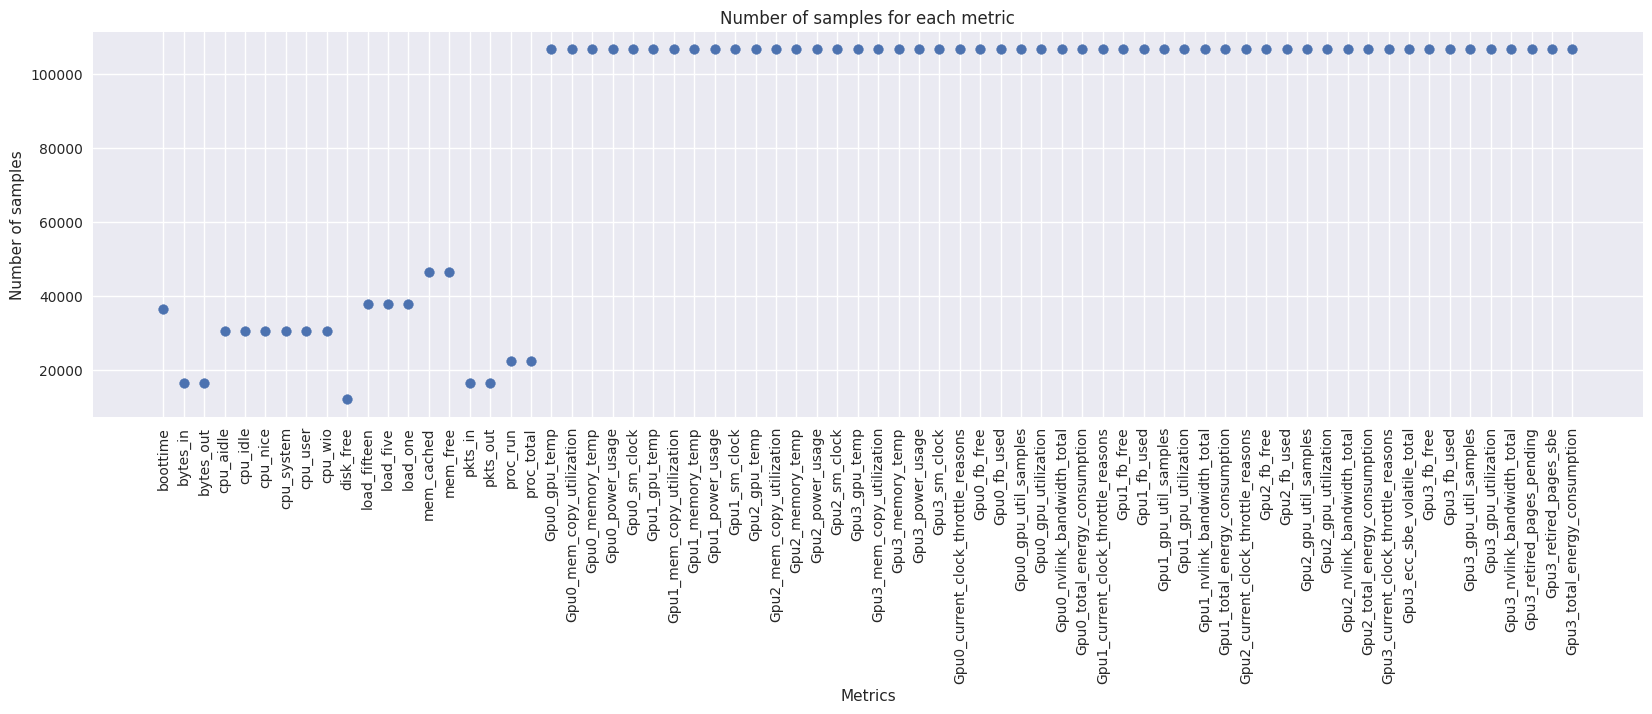

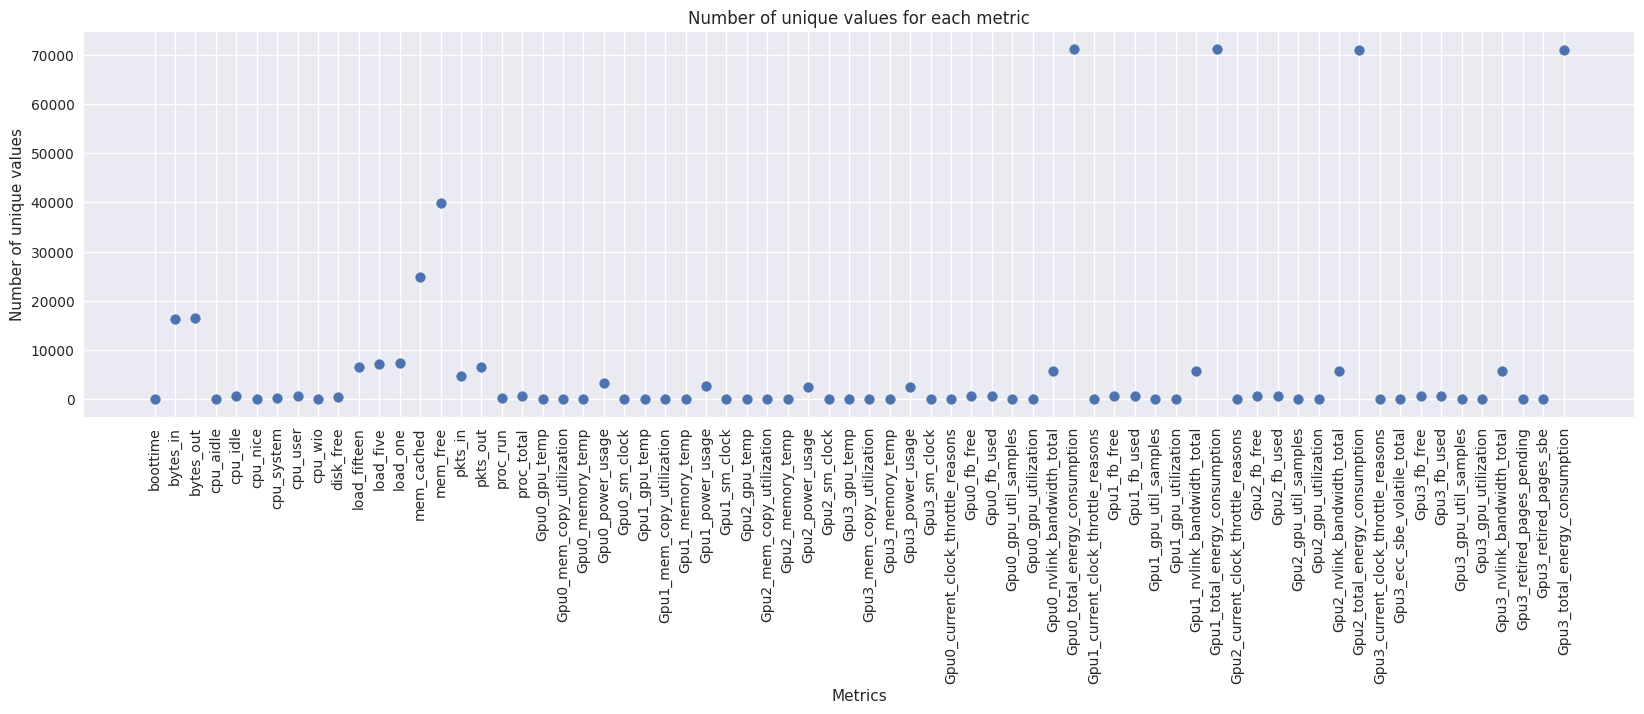

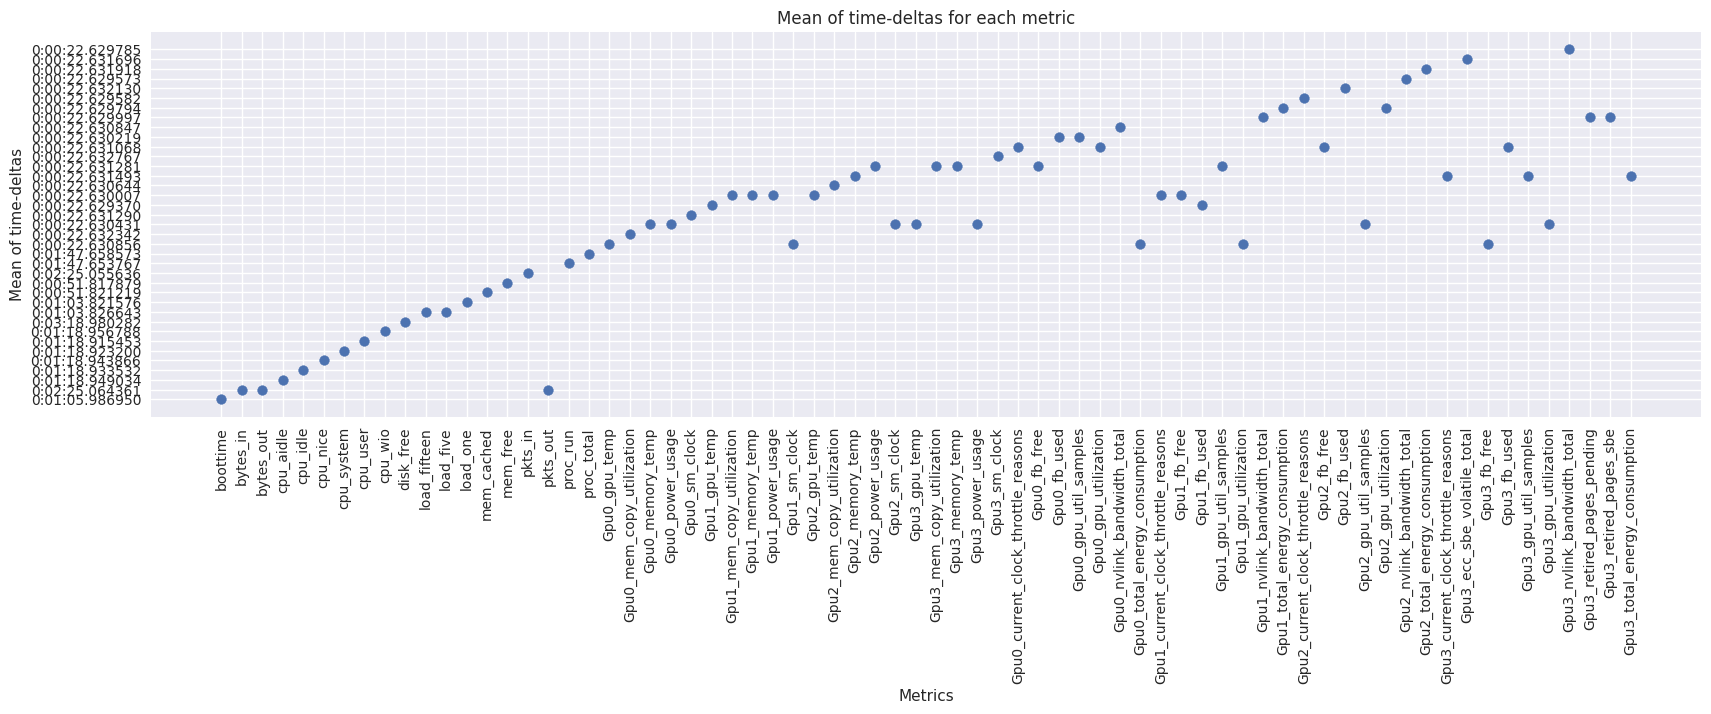

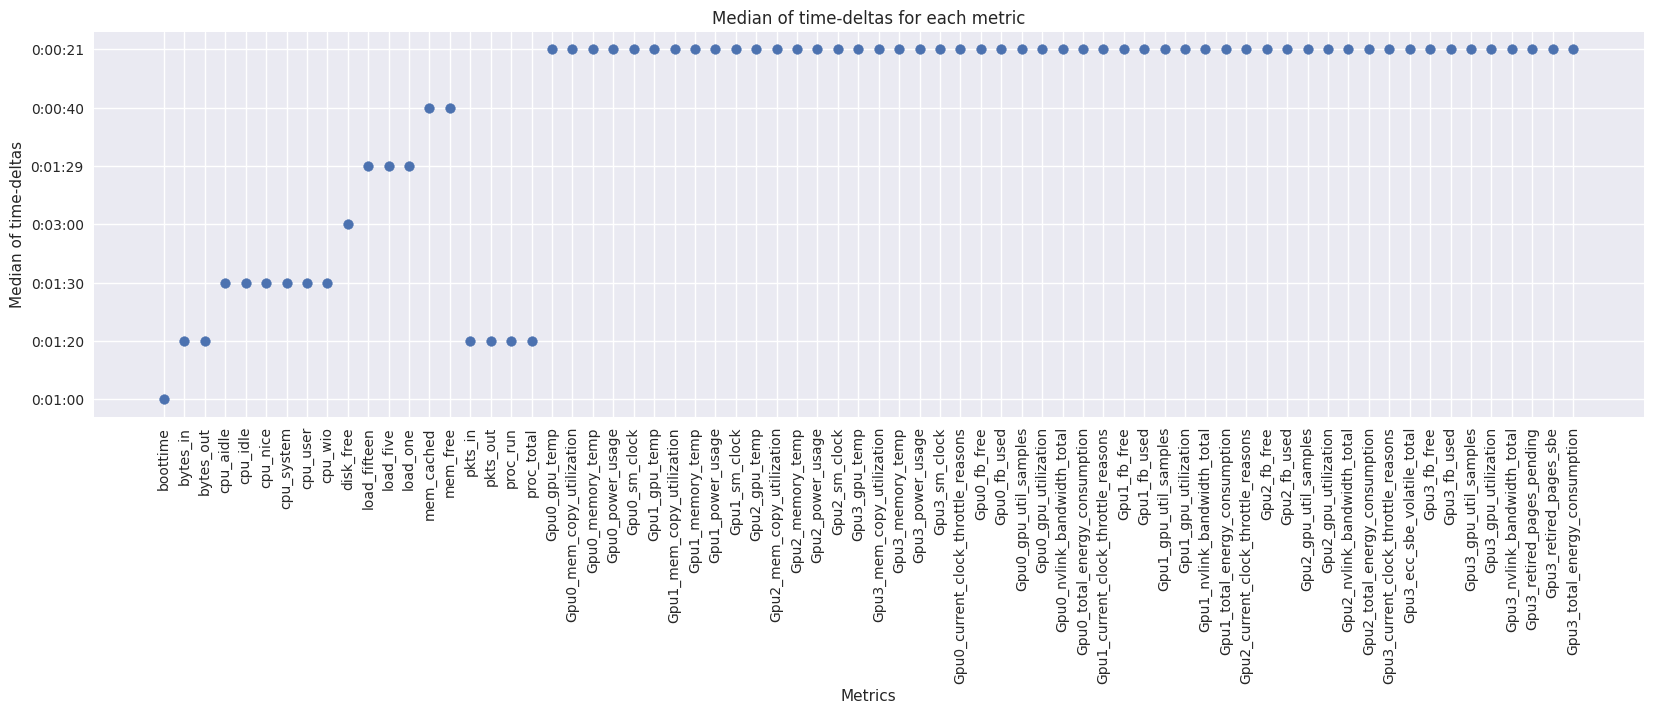

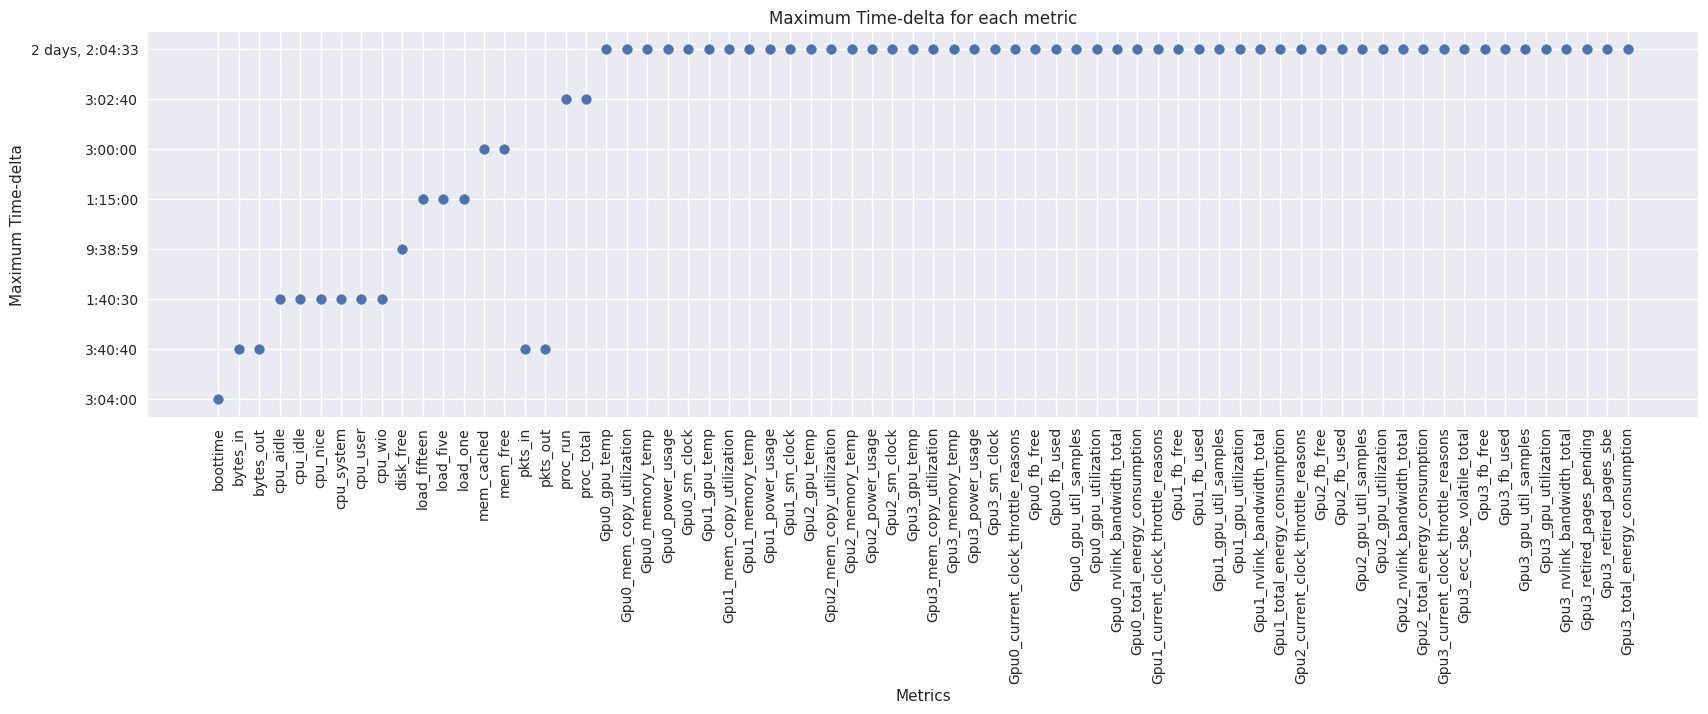

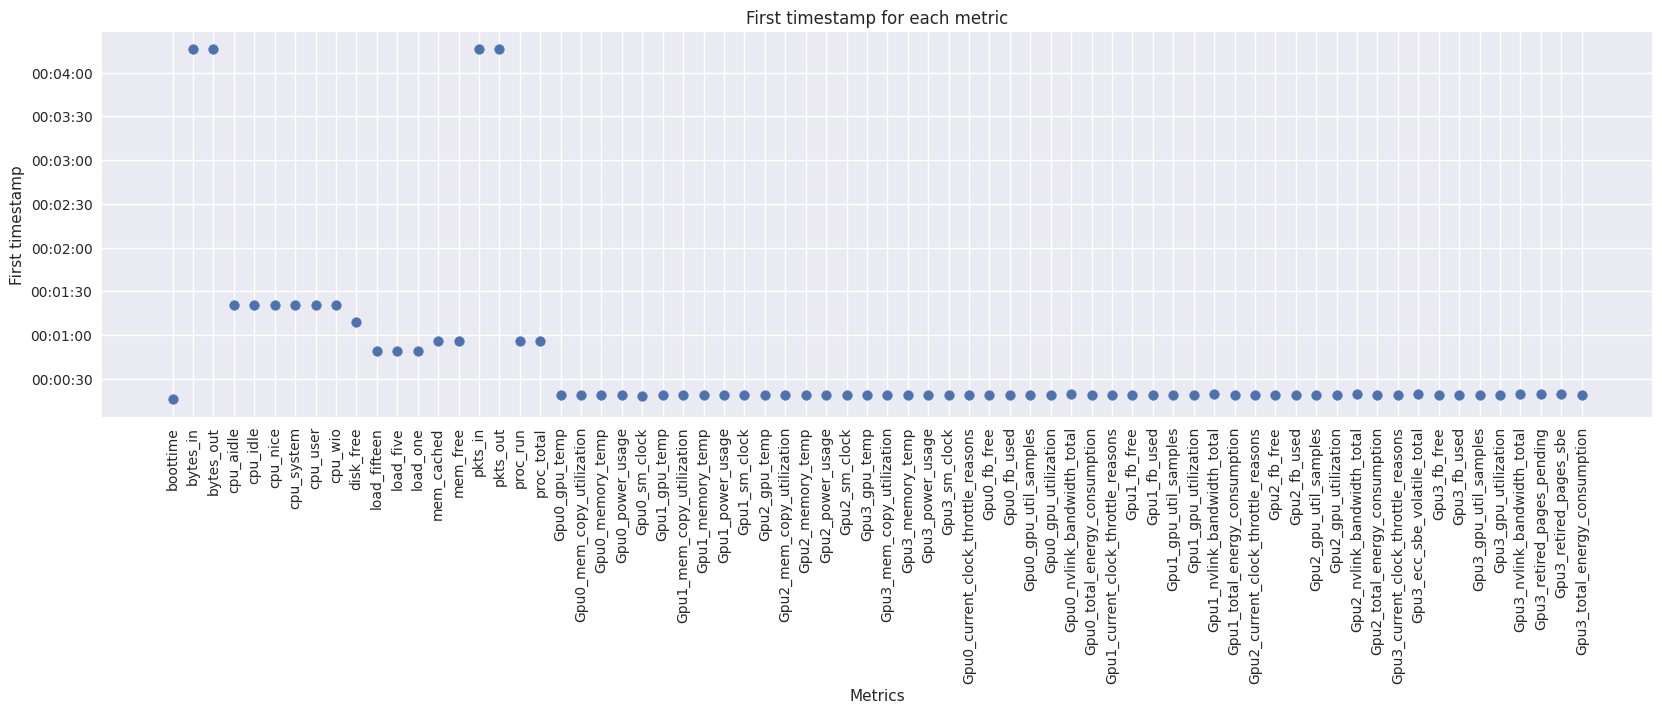

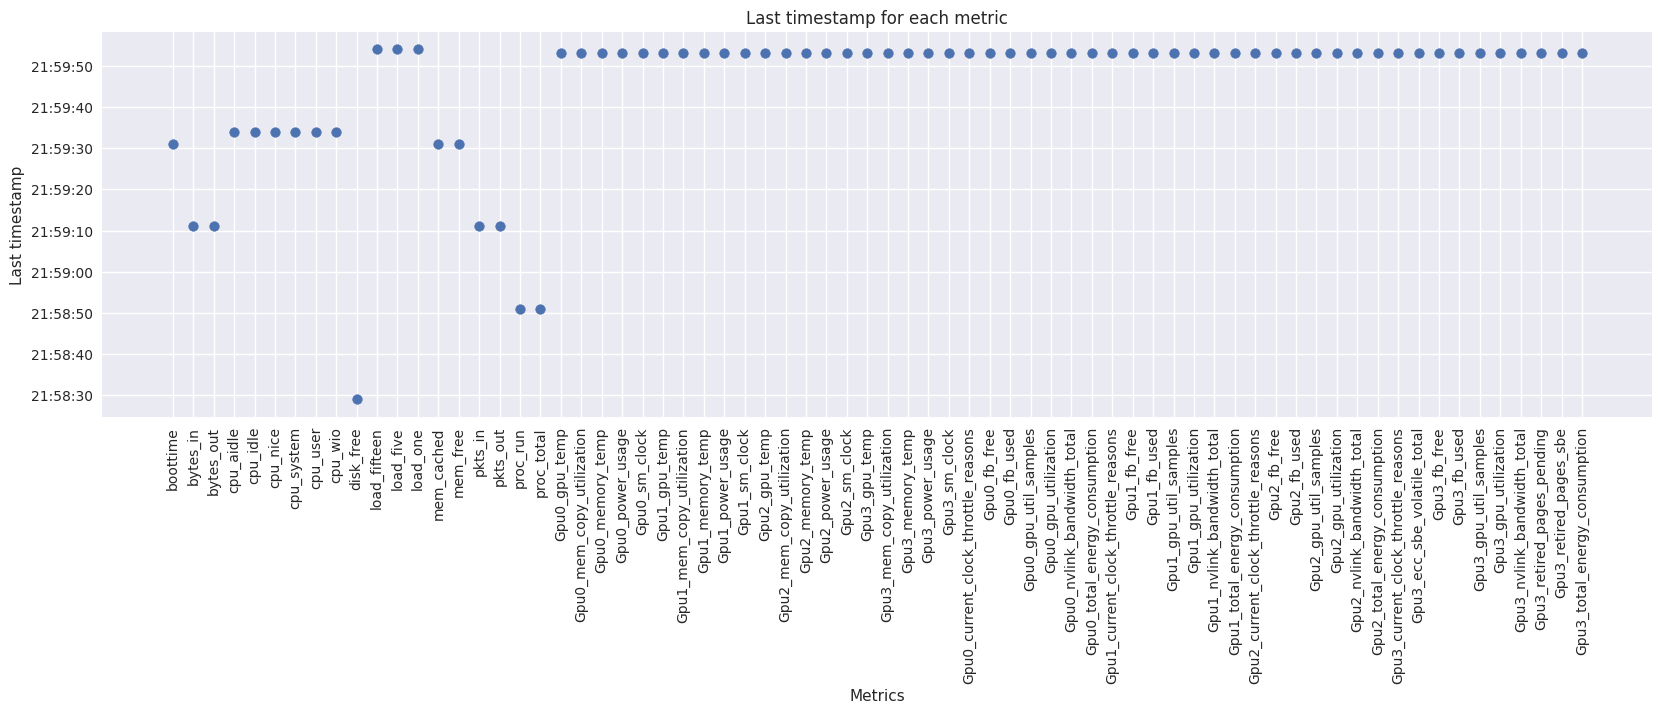

In [110]:
import matplotlib.pyplot as plt


def plot_samples_per_metric(df: pd.DataFrame):
    stats = {
        "Number of samples": [],
        "Number of unique values": [],
        "Mean of time-deltas": [],
        "Median of time-deltas": [],
        "Maximum Time-delta": [],
        "First timestamp": [],
        "Last timestamp": [],
    }

    for metric in metrics:
        # Build a new temporary df for each metric
        df_temp: pd.DataFrame = df.loc[df["metric"] == metric].reset_index()
        # New column of delta-times between each sample and the previous
        df_temp["timedelta"] = df_temp["timestamp"].diff().dt.total_seconds()

        stats["Number of samples"].append(df_temp["timestamp"].shape[0])  # number of samples
        stats["Number of unique values"].append(len(df_temp["value"].unique()))  # number of unique values
        stats["Mean of time-deltas"].append(
            str(timedelta(seconds=df_temp["timedelta"].mean()))
        )  # mean of delta-times of all samples
        stats["Median of time-deltas"].append(
            str(timedelta(seconds=df_temp["timedelta"].median()))
        )  # median of delta-times of all samples
        stats["Maximum Time-delta"].append(
            str(timedelta(seconds=df_temp["timedelta"].max()))
        )  # max of delta-time ever intercurred
        stats["First timestamp"].append(df_temp["timestamp"].min())  # first and last timestamp
        stats["Last timestamp"].append(df_temp["timestamp"].max())

    # Creazione dei grafici
    for stat_name, values in stats.items():
        plt.figure(figsize=(20, 5))
        plt.scatter(metrics, values)
        plt.xlabel("Metrics")
        plt.tick_params(axis="x", labelrotation=90)
        plt.ylabel(stat_name)
        plt.title(f"{stat_name} for each metric")
        plt.show()


plot_samples_per_metric(df_ganglia)

## Build the new dataframe

In [192]:
def rebuild_dataframe(df):
    df_rebuild = pd.DataFrame()
    for metric in metrics:
        df_temp = df.loc[df["metric"] == metric][["timestamp", "value"]].rename(columns={"value": str(metric)})
        if df_rebuild.empty:
            df_rebuild = df_temp
        else:
            df_rebuild = pd.merge(df_rebuild, df_temp, on=["timestamp"], how="outer")
    return df_rebuild.sort_values(by="timestamp").reset_index(drop=True)


df_ganglia_rebuild = rebuild_dataframe(df_ganglia)

In [193]:
# Aggregation timestamps according to nagios timedelta
def aggregate_timestamps(df):
    return df.set_index("timestamp").resample(f"{NAGIOS_TIME_DELTA_MINS}min").mean()


df_ganglia_rebuild = aggregate_timestamps(df_ganglia_rebuild)

display(df_ganglia_rebuild.head(3))
df_ganglia_rebuild.info()

boottime     bytes_in     bytes_out  cpu_aidle  \
timestamp                                                                       
2022-09-01 00:00:00+00:00  1657003790.0  6628.905692  20938.390067  87.099998   
2022-09-01 00:15:00+00:00  1657003790.0  7468.679954   21849.30593  87.099998   
2022-09-01 00:30:00+00:00  1657003790.0  7473.808865    22130.1977  87.099998   

                            cpu_idle cpu_nice cpu_system cpu_user cpu_wio  \
timestamp                                                                   
2022-09-01 00:00:00+00:00  74.900001      0.0       1.26    23.82     0.0   
2022-09-01 00:15:00+00:00  74.870001      0.0        1.2    23.92     0.0   
2022-09-01 00:30:00+00:00  74.910001      0.0       1.38     23.7     0.0   

                             disk_free  ...  \
timestamp                               ...   
2022-09-01 00:00:00+00:00  1134.354395  ...   
2022-09-01 00:15:00+00:00  1134.352002  ...   
2022-09-01 00:30:00+00:00  1134.350952  ...   

                          Gpu3_current_clock_throttle_reasons  \
timestamp                                                       
2022-09-01 00:00:00+00:00                                 0.0   
2022-09-01 00:15:00+00:00                                 0.0   
2022-09-01 00:30:00+00:00                                 0.0   

                          Gpu3_ecc_sbe_volatile_total Gpu3_fb_free  \
timestamp                                                            
2022-09-01 00:00:00+00:00                         1.0      15694.0   
2022-09-01 00:15:00+00:00                         1.0      15694.0   
2022-09-01 00:30:00+00:00                         1.0      15694.0   

                          Gpu3_fb_used Gpu3_gpu_util_samples  \
timestamp                                                      
2022-09-01 00:00:00+00:00        466.0             19.933333   
2022-09-01 00:15:00+00:00        466.0             19.866667   
2022-09-01 00:30:00+00:00        466.0             19.909091   

                          Gpu3_gpu_utilization Gpu3_nvlink_bandwidth_total  \
timestamp                                                                    
2022-09-01 00:00:00+00:00                 19.8                 2046.555556   
2022-09-01 00:15:00+00:00            21.088889                 2044.511111   
2022-09-01 00:30:00+00:00            21.159091                 2046.613636   

                          Gpu3_retired_pages_pending Gpu3_retired_pages_sbe  \
timestamp                                                                     
2022-09-01 00:00:00+00:00                        0.0                    0.0   
2022-09-01 00:15:00+00:00                        0.0                    0.0   
2022-09-01 00:30:00+00:00                        0.0                    0.0   

                          Gpu3_total_energy_consumption  
timestamp                                                
2022-09-01 00:00:00+00:00           546234708635.177795  
2022-09-01 00:15:00+00:00           546311383497.222229  
2022-09-01 00:30:00+00:00           546387312163.431824  

[3 rows x 70 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2680 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Freq: 15T
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   boottime                             2580 non-null   object
 1   bytes_in                             2554 non-null   object
 2   bytes_out                            2554 non-null   object
 3   cpu_aidle                            2631 non-null   object
 4   cpu_idle                             2631 non-null   object
 5   cpu_nice                             2631 non-null   object
 6   cpu_system                           2631 non-null   object
 7   cpu_user                             2631 non-null   object
 8   cpu_wio                              2631 non-null   object
 9   disk_free                            2524 non-null   object
 10  load_fifteen                         2635 non-null

In [194]:
df_ganglia_rebuild.dropna(how="all")

boottime     bytes_in     bytes_out  cpu_aidle  \
timestamp                                                                       
2022-09-01 00:00:00+00:00  1657003790.0  6628.905692  20938.390067  87.099998   
2022-09-01 00:15:00+00:00  1657003790.0  7468.679954   21849.30593  87.099998   
2022-09-01 00:30:00+00:00  1657003790.0  7473.808865    22130.1977  87.099998   
2022-09-01 00:45:00+00:00  1657003790.0  7534.171094   22824.03418  87.099998   
2022-09-01 01:00:00+00:00  1657003790.0  7152.330892  22134.014323  87.099998   
...                                 ...          ...           ...        ...   
2022-09-28 20:45:00+00:00  1662968978.0  6452.180176  15354.379883     87.996   
2022-09-28 21:00:00+00:00  1662968978.0  6652.939941  19239.430176  87.900002   
2022-09-28 21:15:00+00:00  1662968978.0   8422.80249  19872.035156  87.900002   
2022-09-28 21:30:00+00:00  1662968978.0  7613.132031  17742.154297  87.900002   
2022-09-28 21:45:00+00:00  1662968978.0  7018.800049  17640.862305  87.900002   

                            cpu_idle cpu_nice cpu_system   cpu_user cpu_wio  \
timestamp                                                                     
2022-09-01 00:00:00+00:00  74.900001      0.0       1.26      23.82     0.0   
2022-09-01 00:15:00+00:00  74.870001      0.0        1.2      23.92     0.0   
2022-09-01 00:30:00+00:00  74.910001      0.0       1.38       23.7     0.0   
2022-09-01 00:45:00+00:00  74.910001      0.0       1.33      23.73     0.0   
2022-09-01 01:00:00+00:00      74.92      0.0       1.28      23.82     0.0   
...                              ...      ...        ...        ...     ...   
2022-09-28 20:45:00+00:00     83.384      0.0       0.18     16.436     0.0   
2022-09-28 21:00:00+00:00     81.025      0.0    0.25625       18.7     0.0   
2022-09-28 21:15:00+00:00   84.13077      0.0   0.346154  15.530769     0.0   
2022-09-28 21:30:00+00:00  79.738888      0.0   0.227778  20.044445     0.0   
2022-09-28 21:45:00+00:00   84.56875      0.0    0.23125       15.2     0.0   

                             disk_free  ...  \
timestamp                               ...   
2022-09-01 00:00:00+00:00  1134.354395  ...   
2022-09-01 00:15:00+00:00  1134.352002  ...   
2022-09-01 00:30:00+00:00  1134.350952  ...   
2022-09-01 00:45:00+00:00  1134.350171  ...   
2022-09-01 01:00:00+00:00  1134.349194  ...   
...                                ...  ...   
2022-09-28 20:45:00+00:00  1134.077393  ...   
2022-09-28 21:00:00+00:00  1134.078784  ...   
2022-09-28 21:15:00+00:00  1134.077612  ...   
2022-09-28 21:30:00+00:00   1134.07605  ...   
2022-09-28 21:45:00+00:00  1134.091187  ...   

                          Gpu3_current_clock_throttle_reasons  \
timestamp                                                       
2022-09-01 00:00:00+00:00                                 0.0   
2022-09-01 00:15:00+00:00                                 0.0   
2022-09-01 00:30:00+00:00                                 0.0   
2022-09-01 00:45:00+00:00                                 0.0   
2022-09-01 01:00:00+00:00                                 0.0   
...                                                       ...   
2022-09-28 20:45:00+00:00                                 1.0   
2022-09-28 21:00:00+00:00                                 1.0   
2022-09-28 21:15:00+00:00                                 1.0   
2022-09-28 21:30:00+00:00                                 1.0   
2022-09-28 21:45:00+00:00                                 1.0   

                          Gpu3_ecc_sbe_volatile_total Gpu3_fb_free  \
timestamp                                                            
2022-09-01 00:00:00+00:00                         1.0      15694.0   
2022-09-01 00:15:00+00:00                         1.0      15694.0   
2022-09-01 00:30:00+00:00                         1.0      15694.0   
2022-09-01 00:45:00+00:00                         1.0      15694.0   
2022-09-01 01:00:00+00:00                         1.0      15694.0   
.

In [195]:
# Save rebuilt dataframe
df_ganglia_rebuild.to_csv(dataset_path_rebuild + "/ganglia_rebuild_node:" + NODE_SELECTED + ".csv", index=True)

In [196]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features$

---
# IPMI

In [197]:
metrics_description(plugin="ipmi")

Plugin: 'ipmi'
metric: 'p1_core18_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'dimm2_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p1_core5_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'ps0_input_power'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p0_core12_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p1_power'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'gpu3_core_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'ps0_output_volta'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p0_core14_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'n

[]

In [198]:
df_ipmi: pd.DataFrame = (
    client.query_plugins(plugins="ipmi", node=NODE_SELECTED)
    .sort_values(by="timestamp", ascending=True)
    .reset_index(drop=True)
)

df_ipmi.info()
display(df_ipmi.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10545344 entries, 0 to 10545343
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   value       Float64            
 1   plugin      category           
 2   node        category           
 3   metric      category           
 4   timestamp   datetime64[ms, UTC]
 5   year_month  category           
dtypes: Float64(1), category(4), datetime64[ms, UTC](1)
memory usage: 231.4 MB


value    plugin node           metric                 timestamp year_month
0   24.0  ipmi_pub  578     p0_mem_power 2022-09-01 00:00:00+00:00        NaN
1  510.0  ipmi_pub  578  ps1_input_power 2022-09-01 00:00:00+00:00        NaN
2   34.0  ipmi_pub  578      dimm13_temp 2022-09-01 00:00:00+00:00        NaN

In [199]:
df_ipmi = remove_non_changing_metrics(df_ipmi)

In [200]:
# Keep only useful columns
df_ipmi = df_ipmi[["timestamp", "value", "metric"]].reset_index(drop=True)

metrics = df_ipmi["metric"].sort_values().unique()

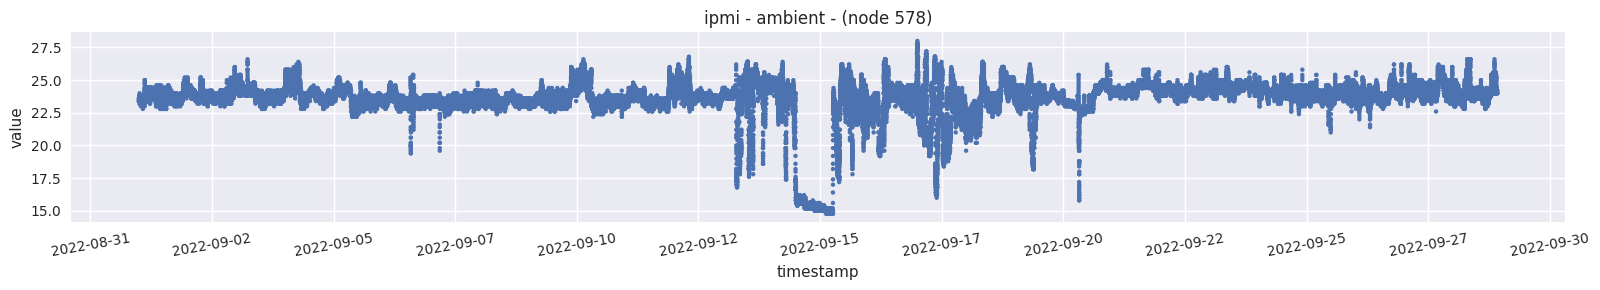

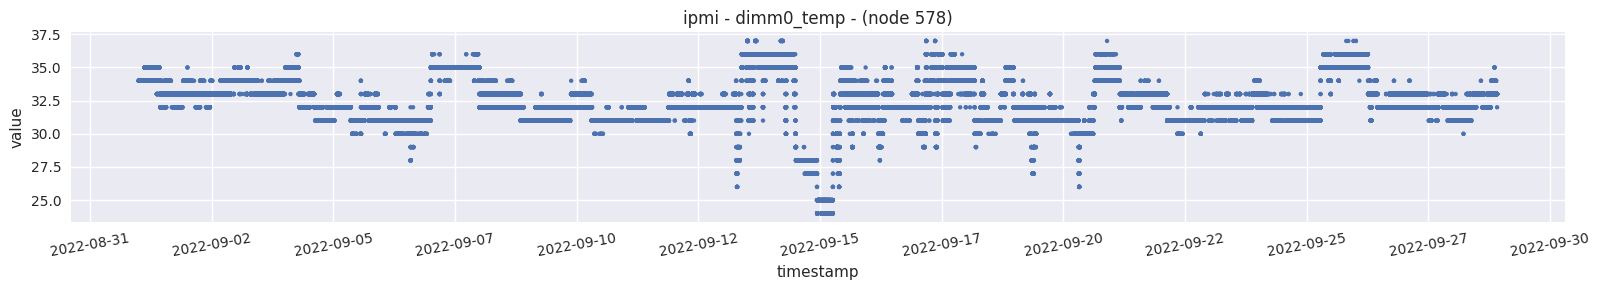

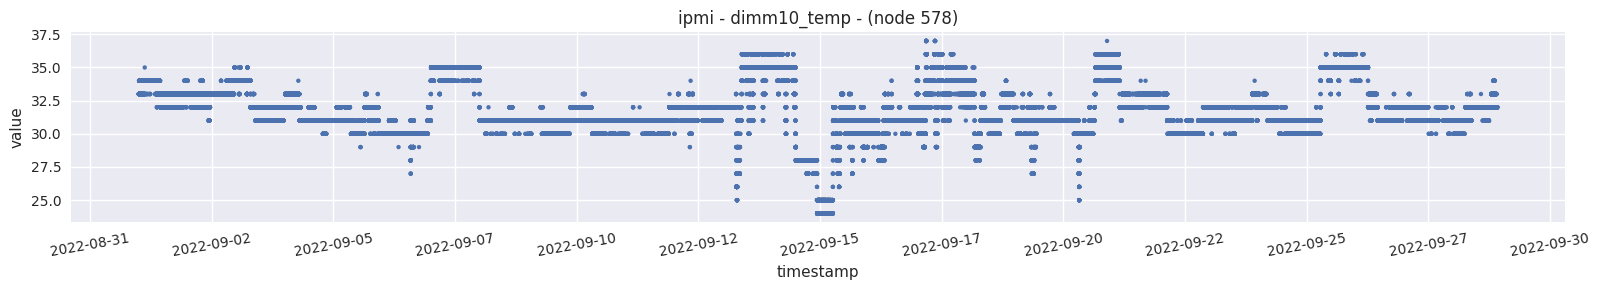

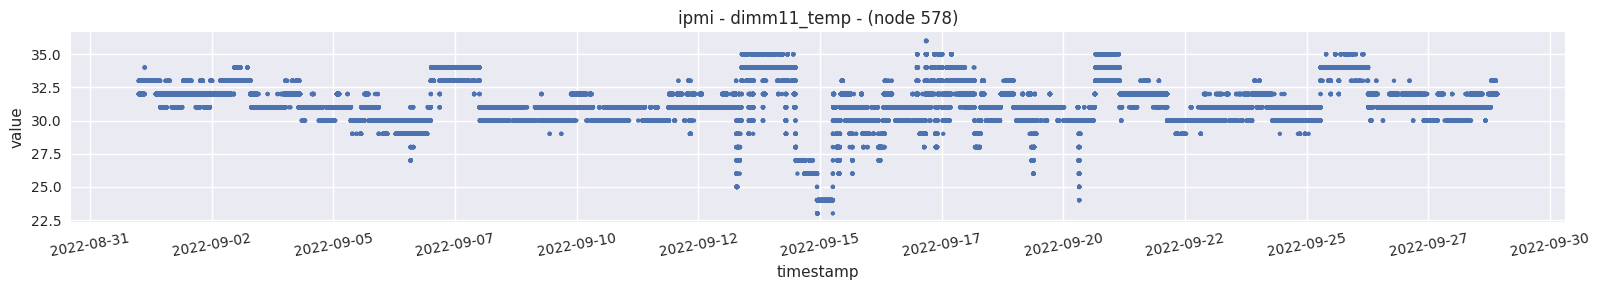

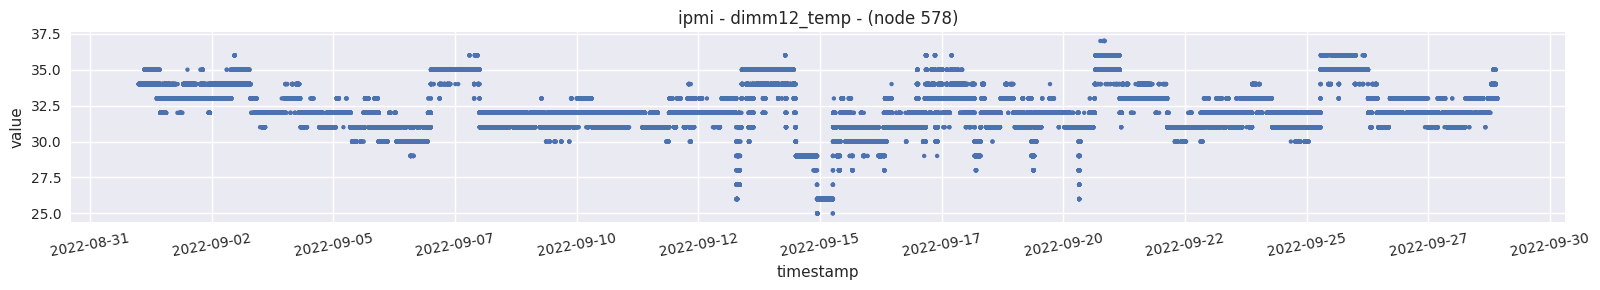

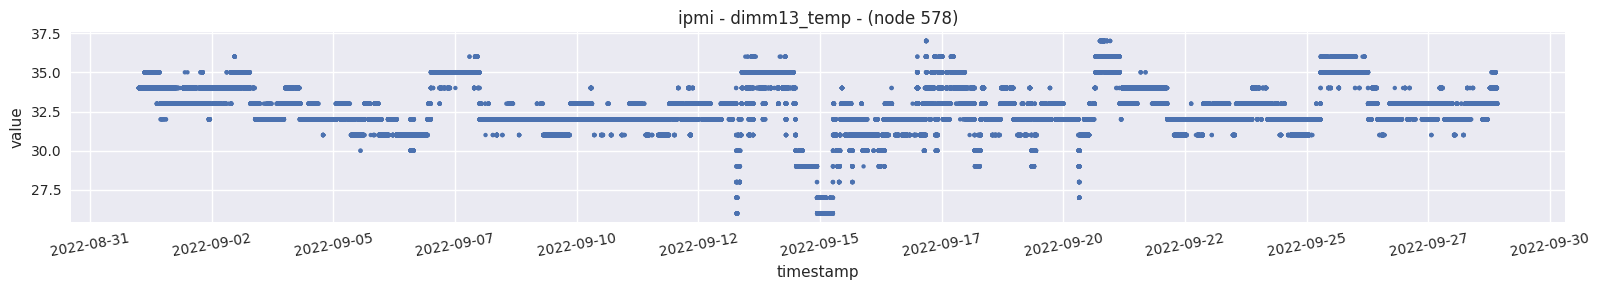

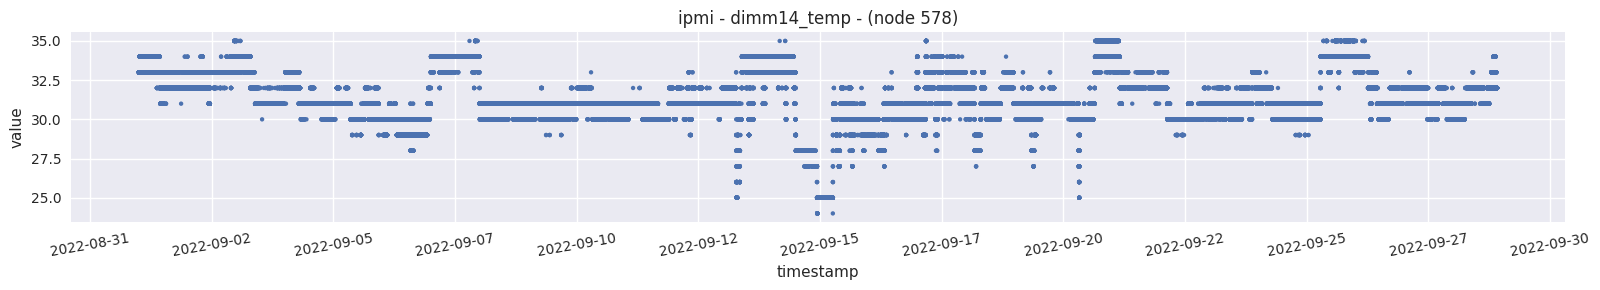

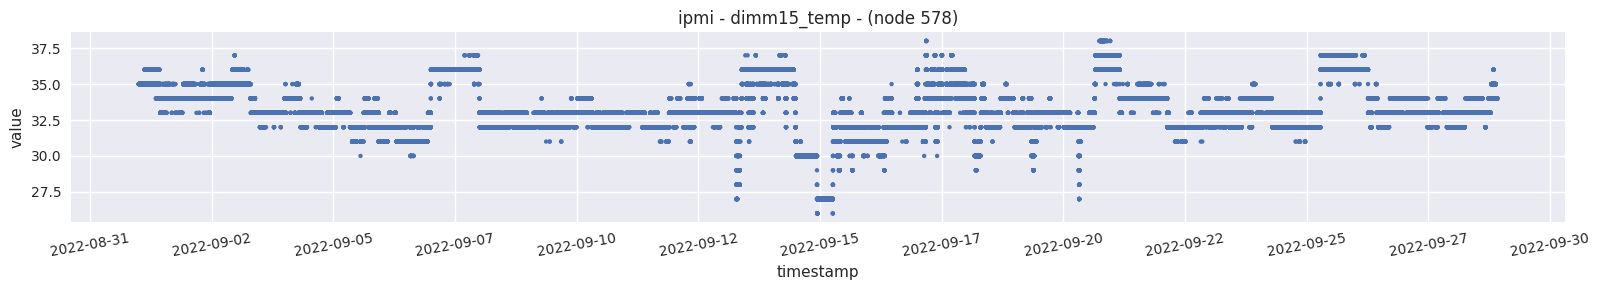

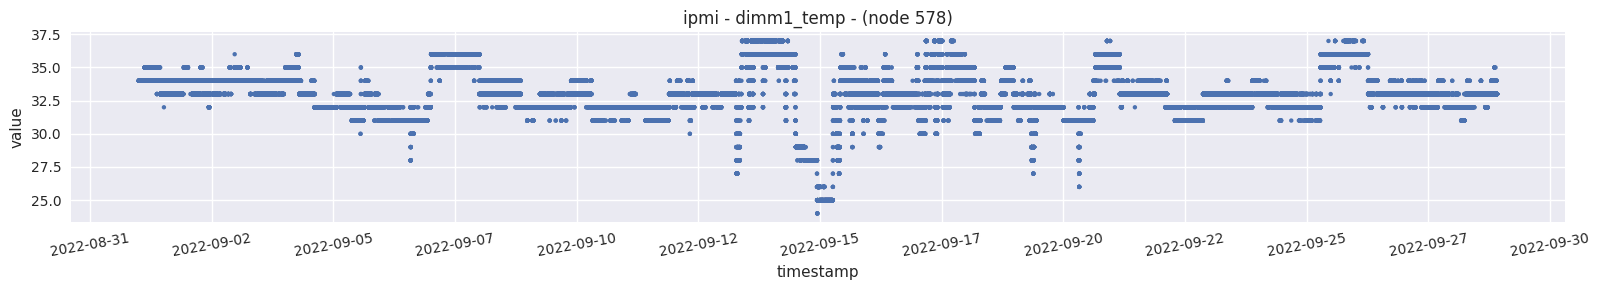

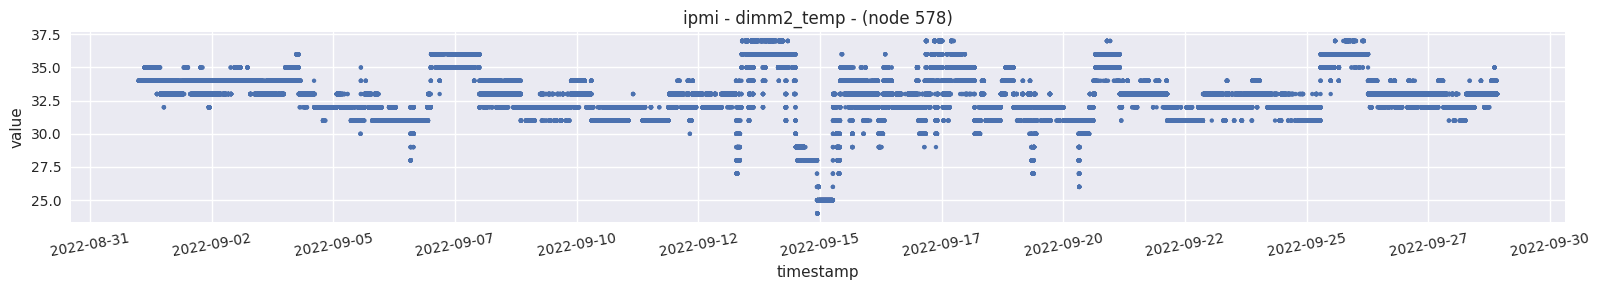

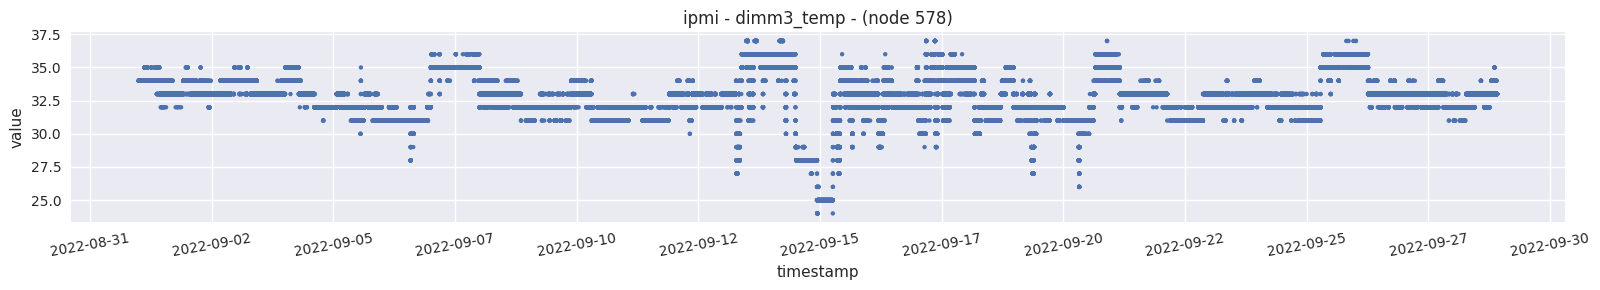

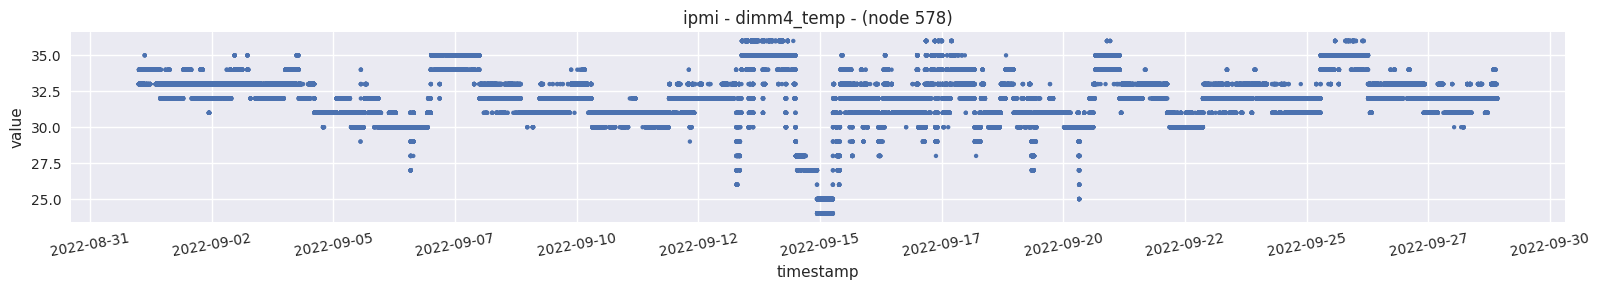

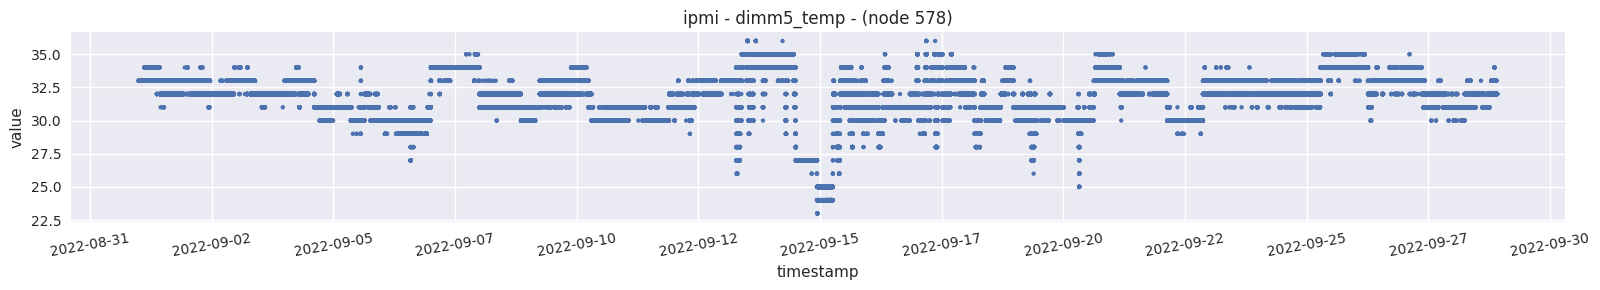

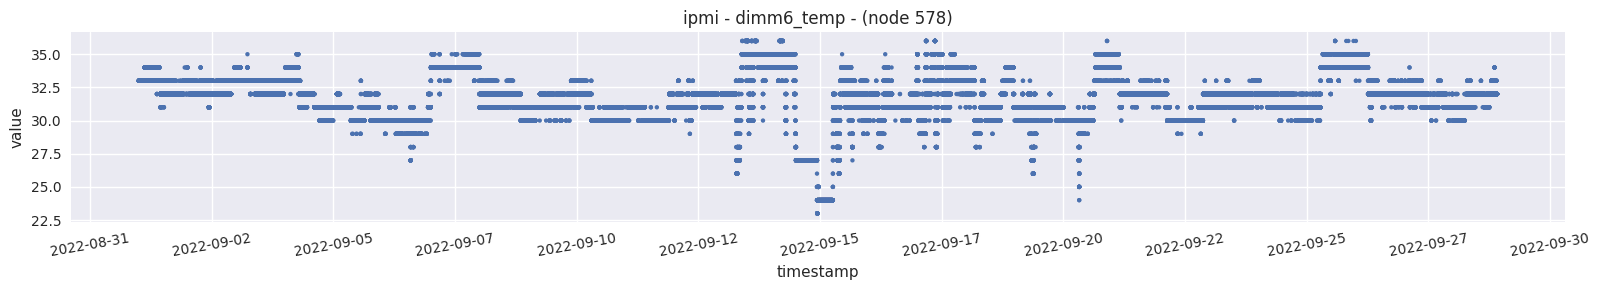

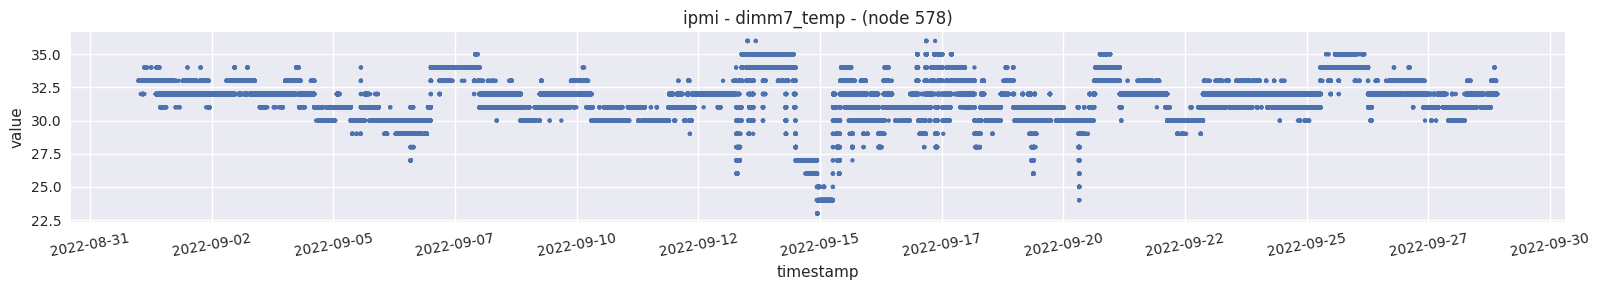

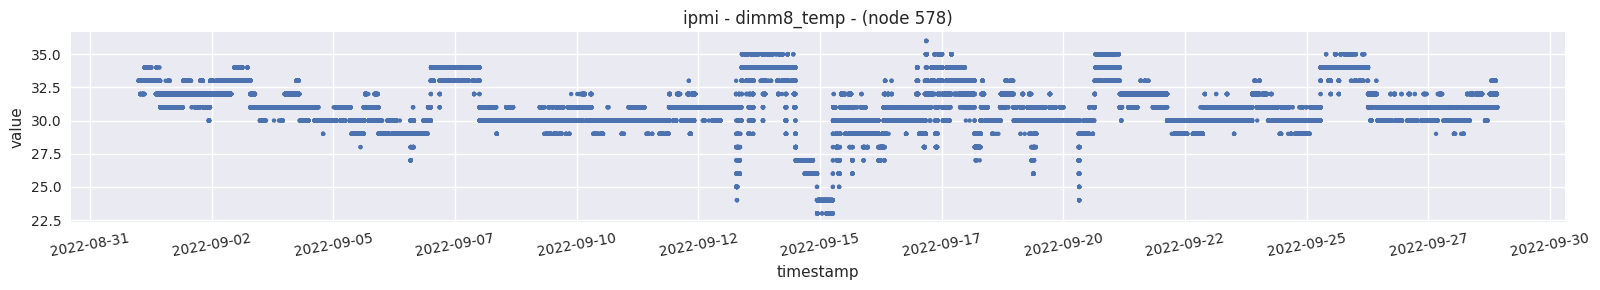

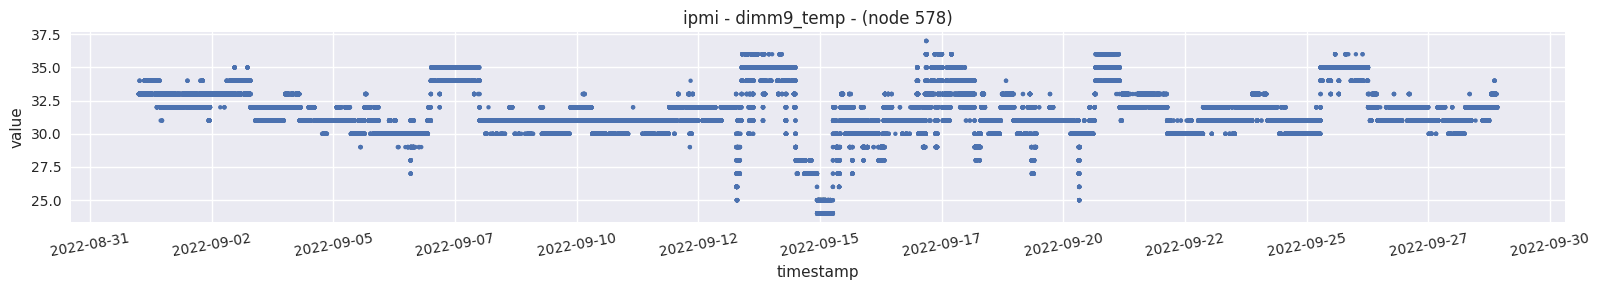

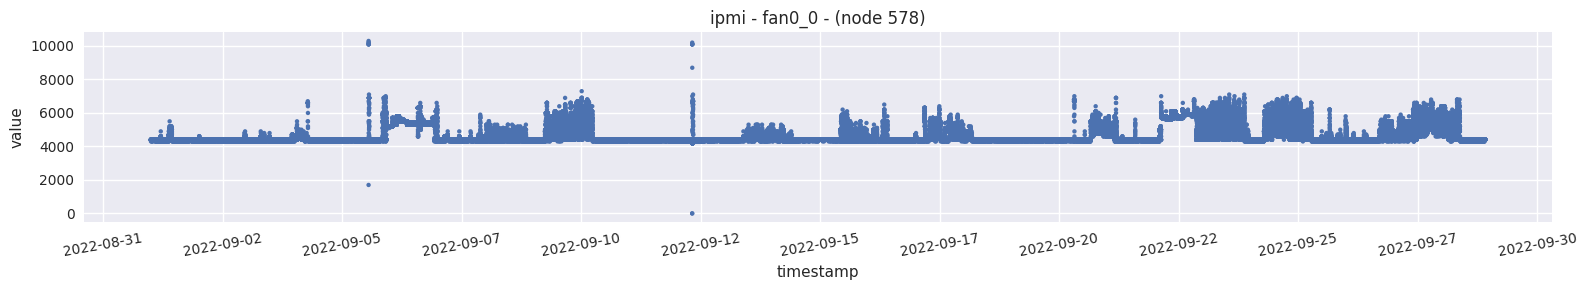

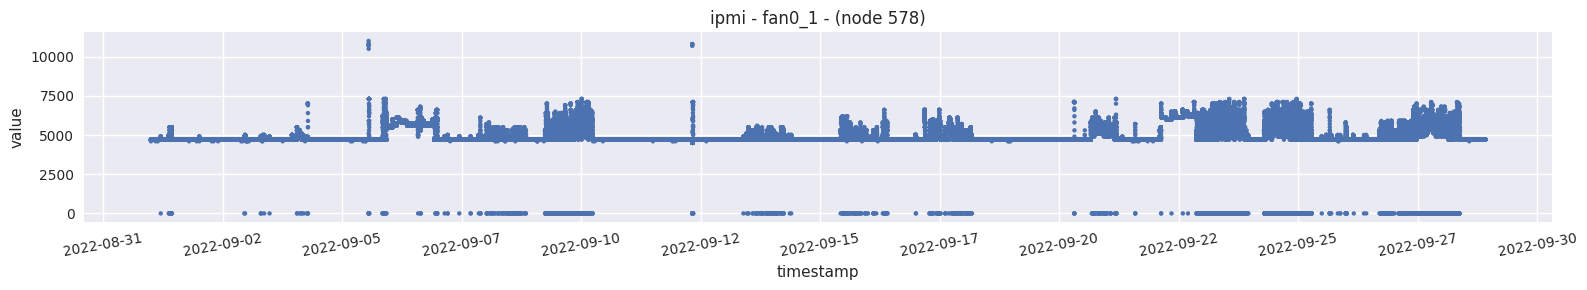

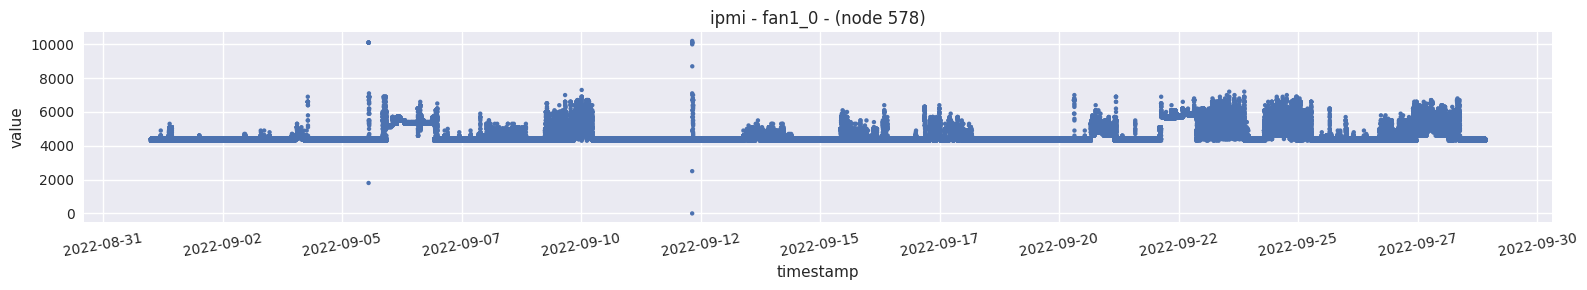

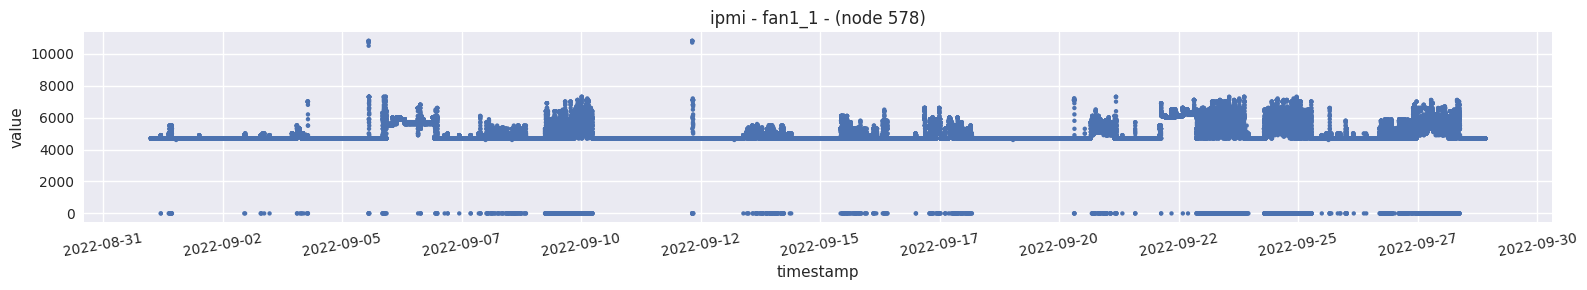

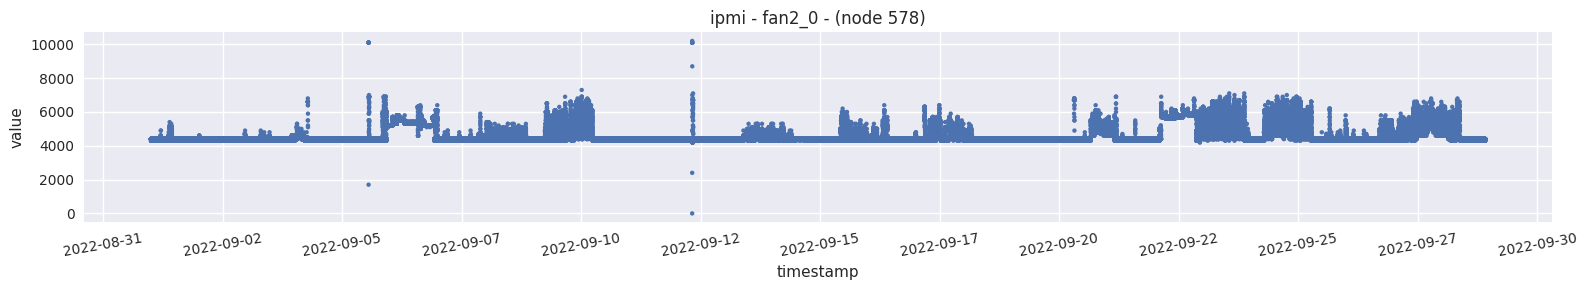

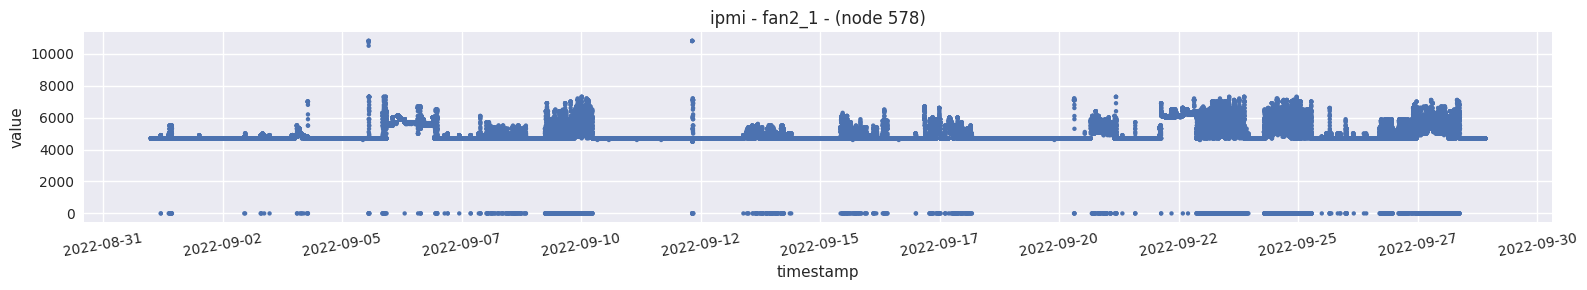

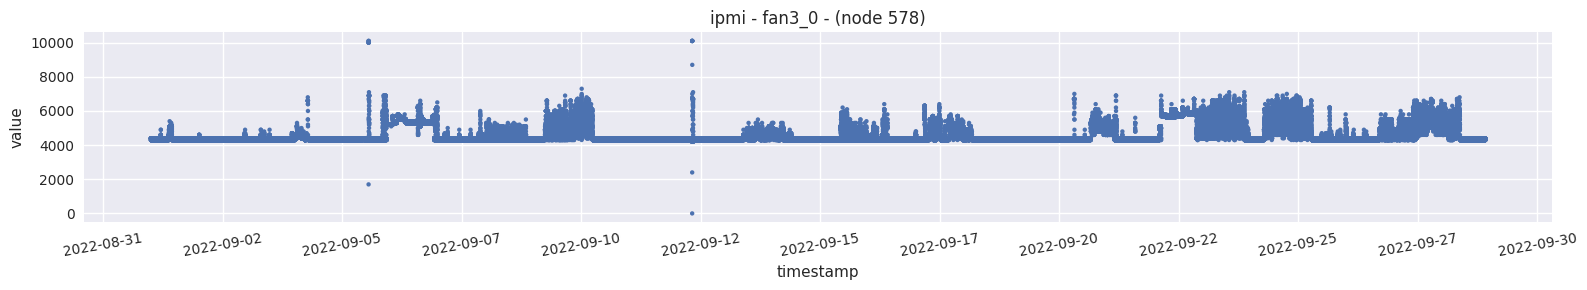

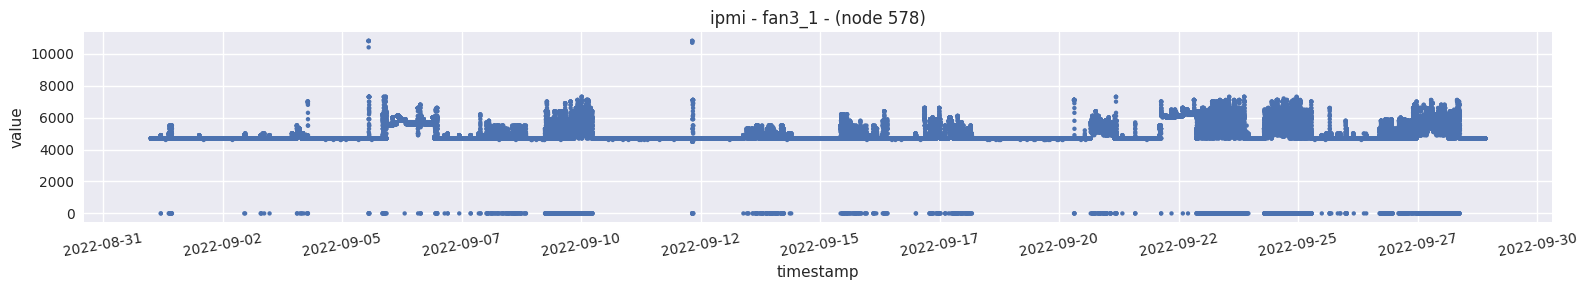

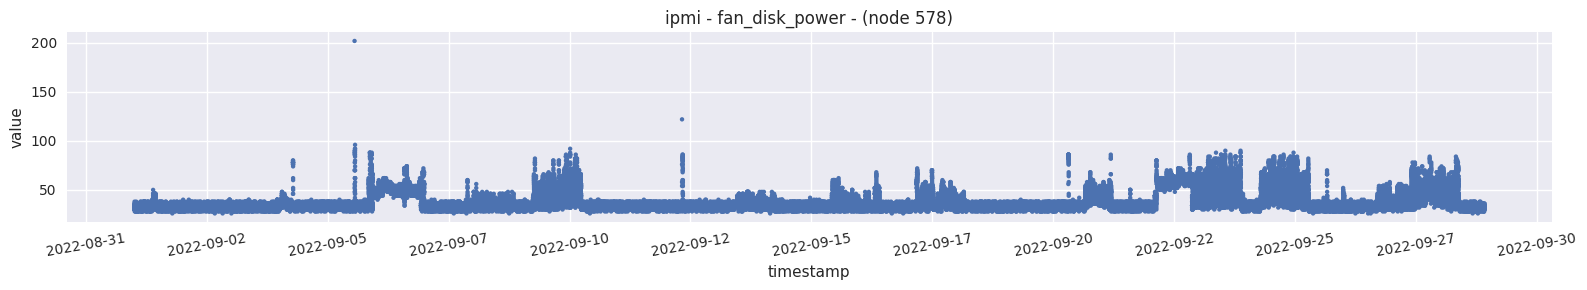

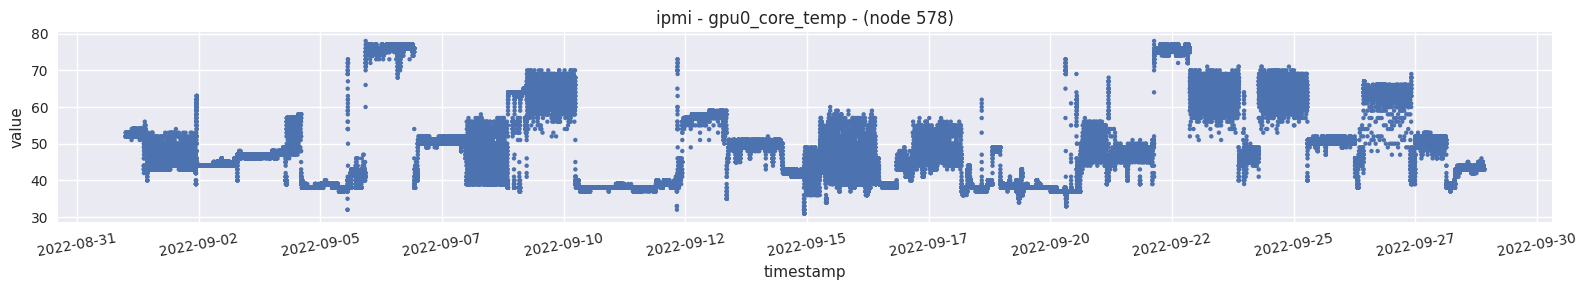

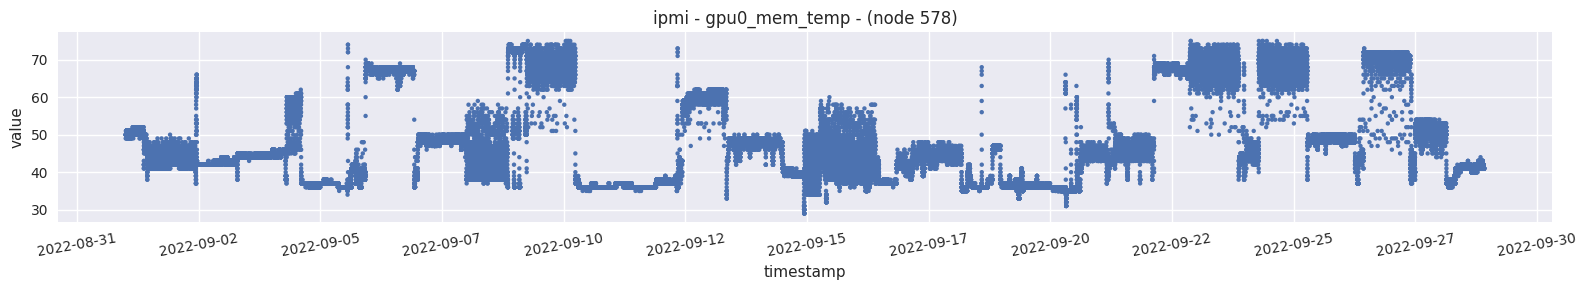

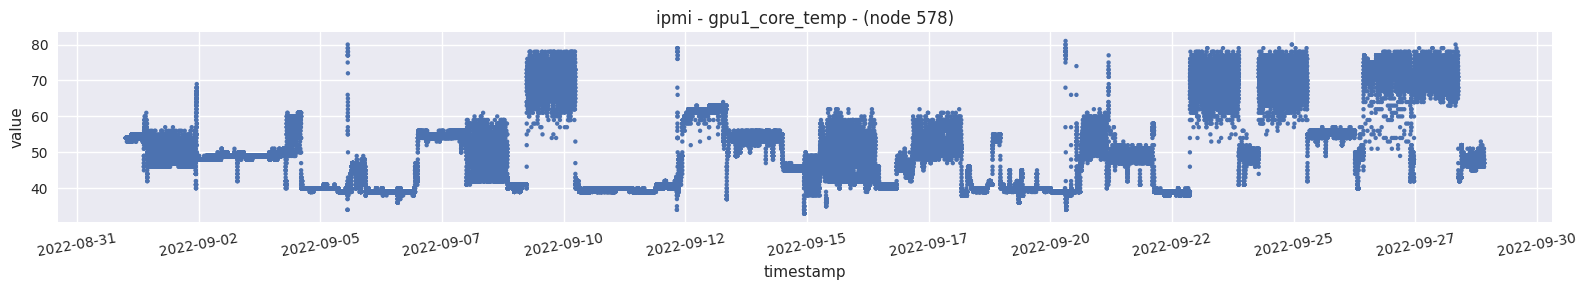

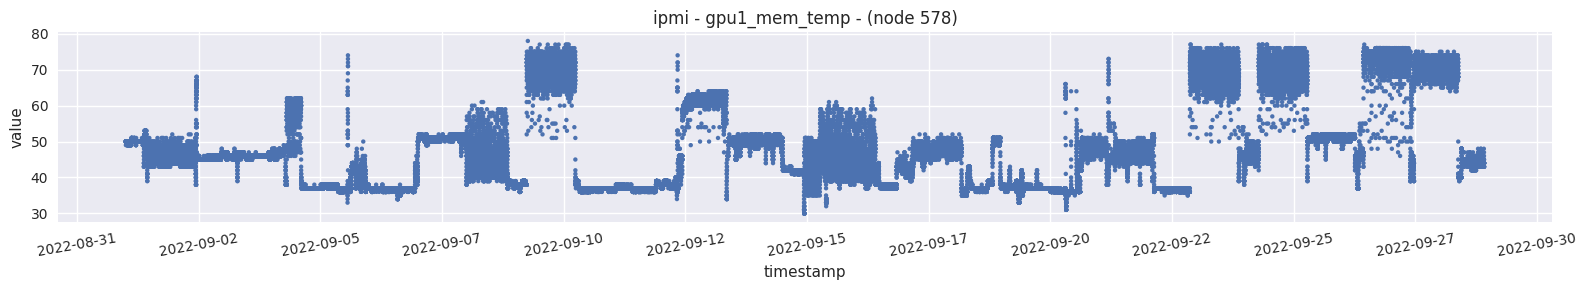

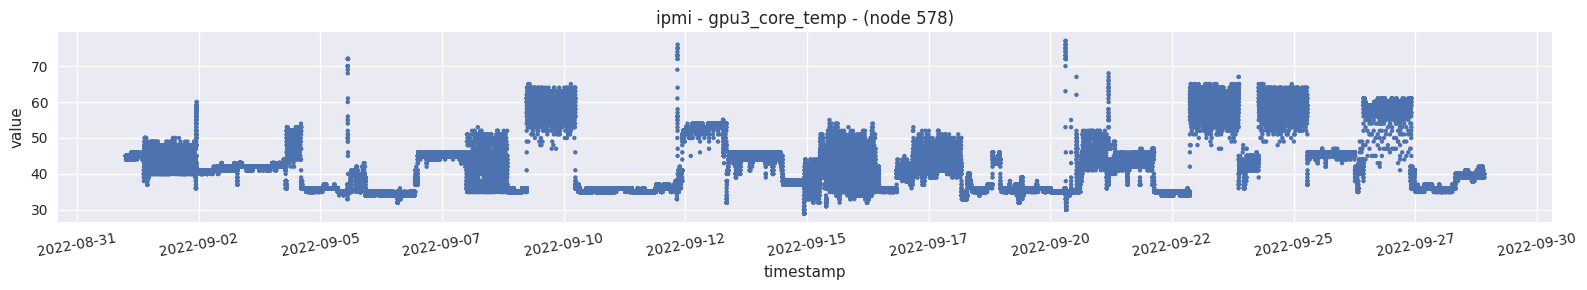

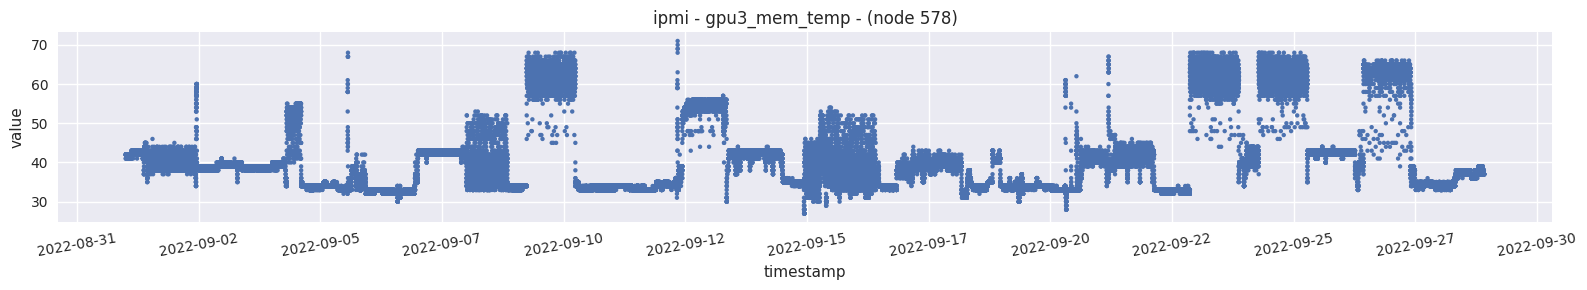

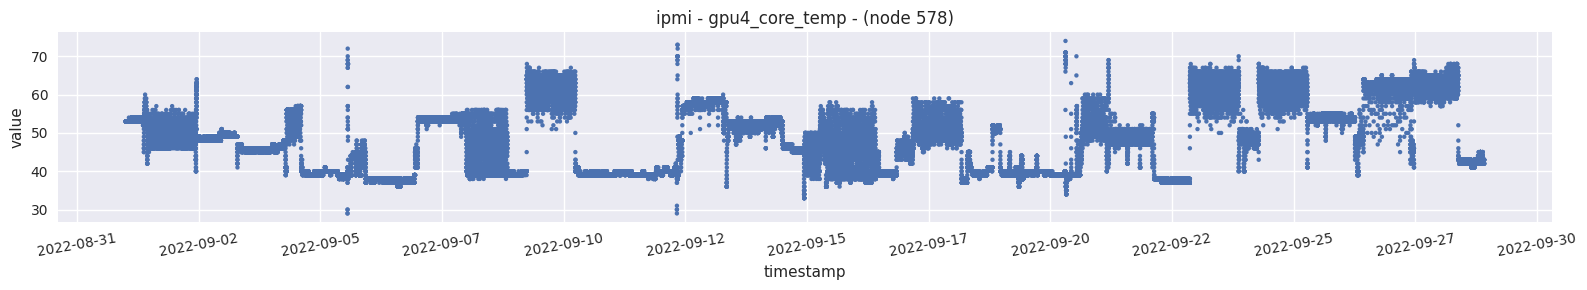

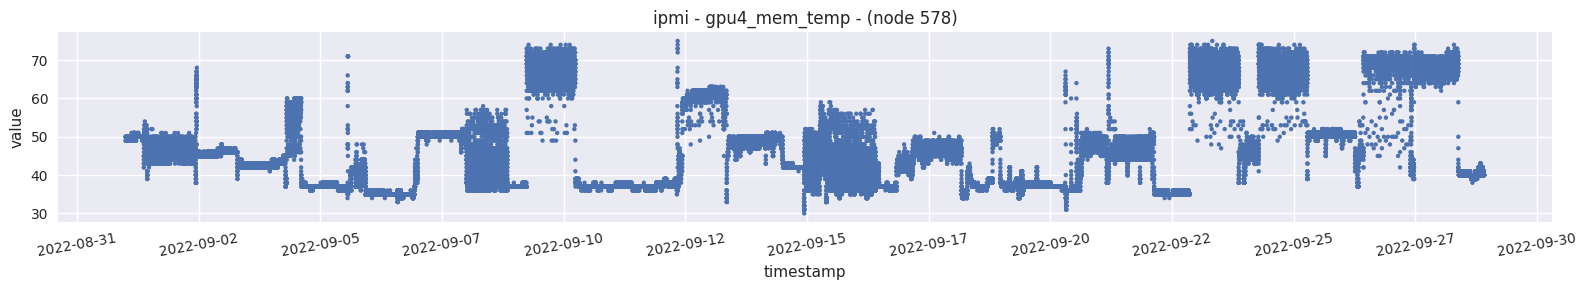

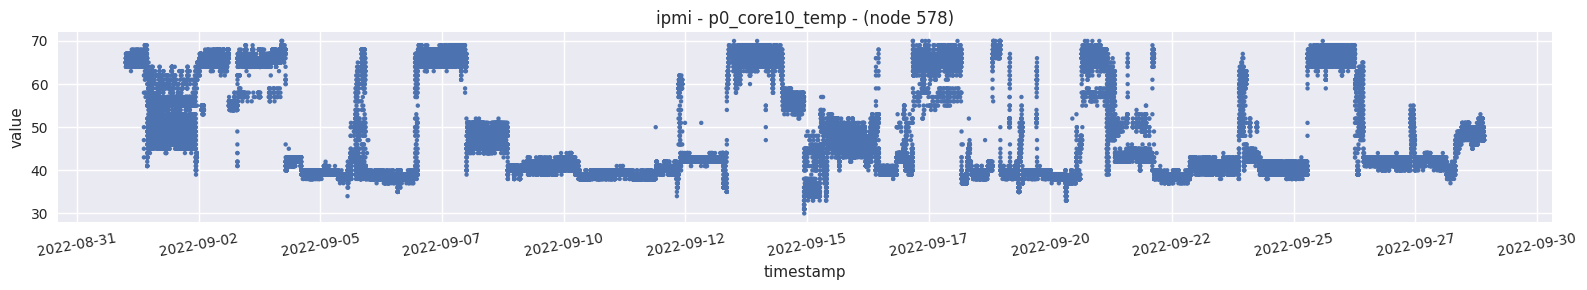

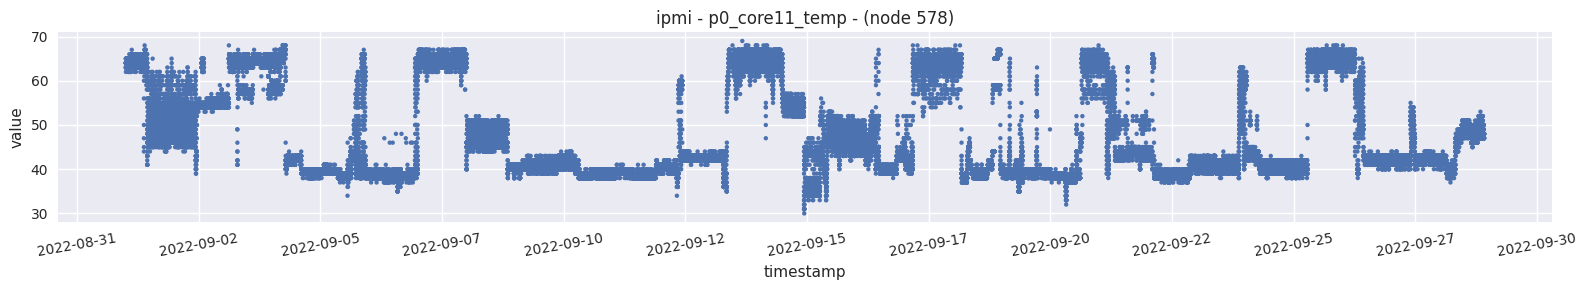

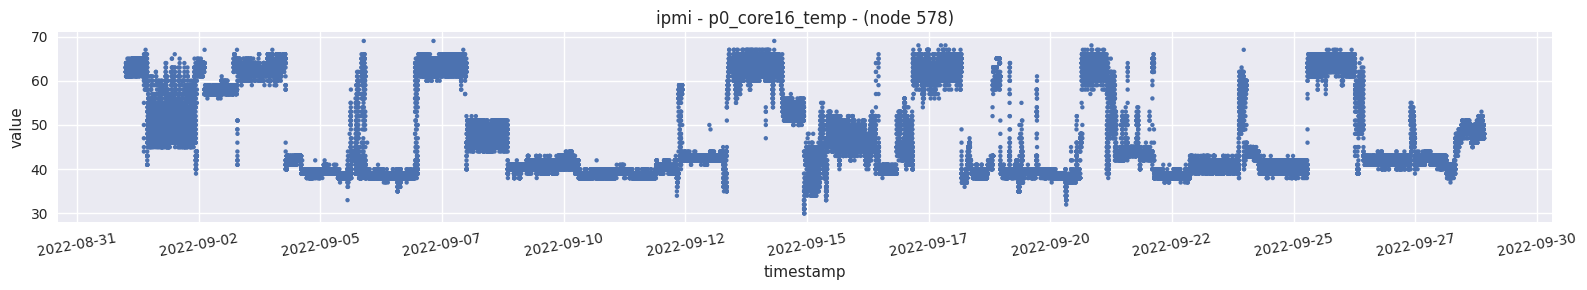

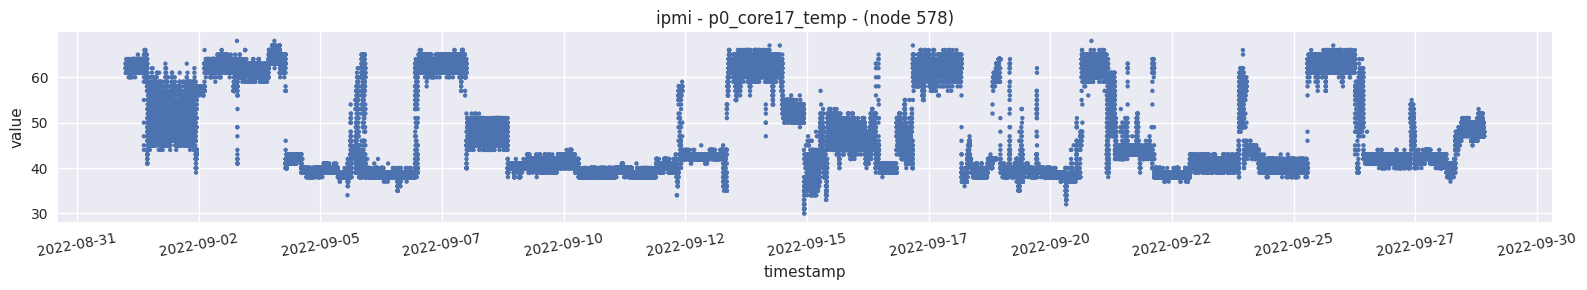

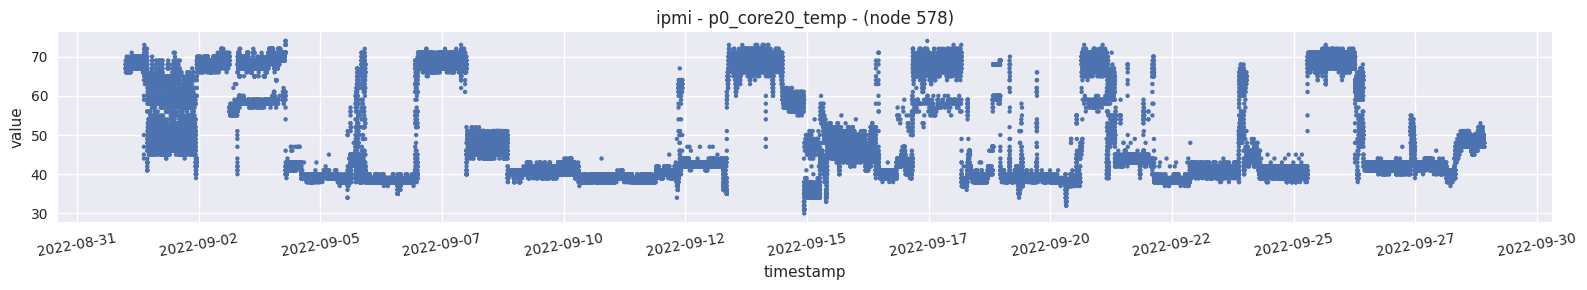

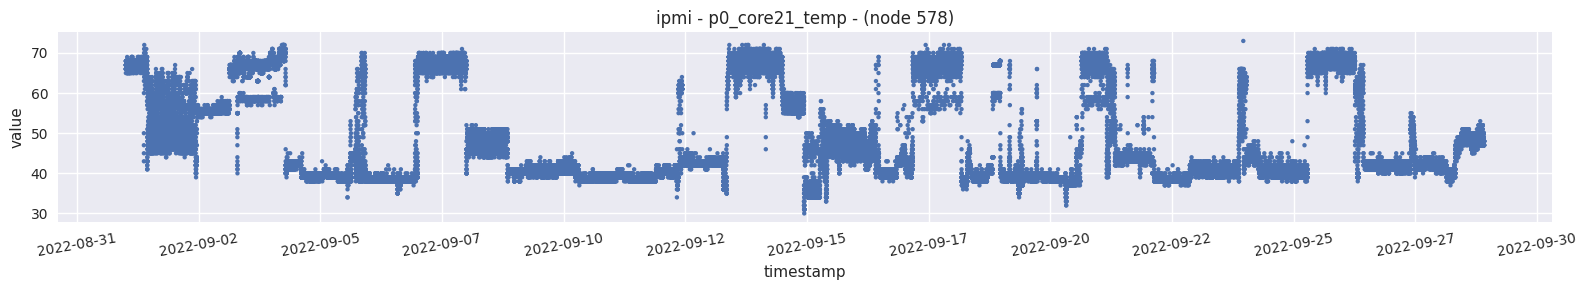

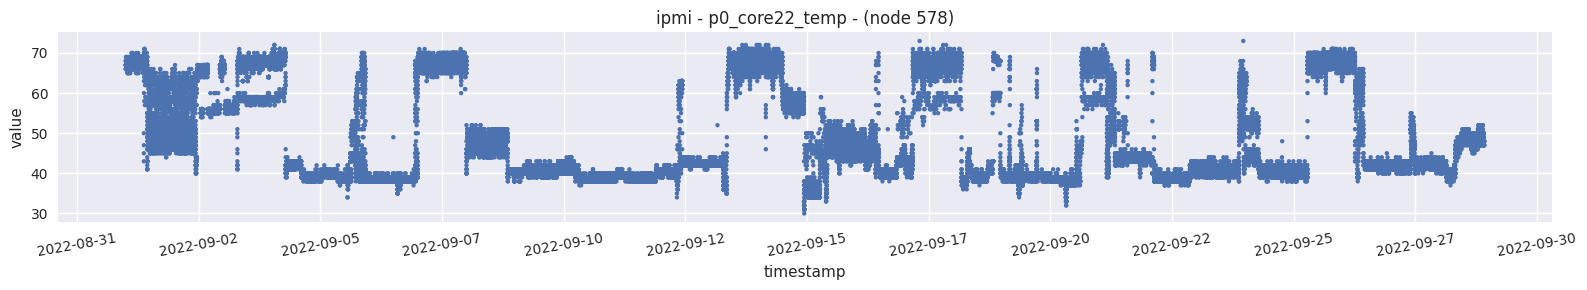

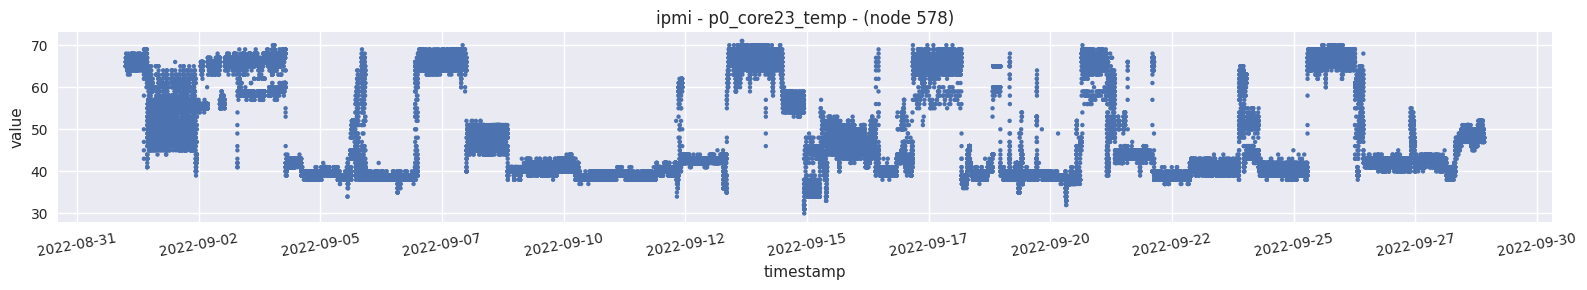

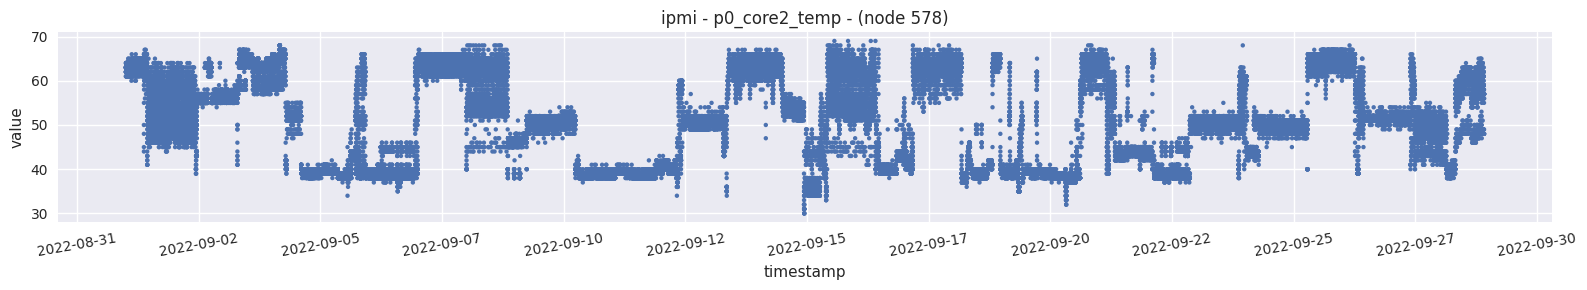

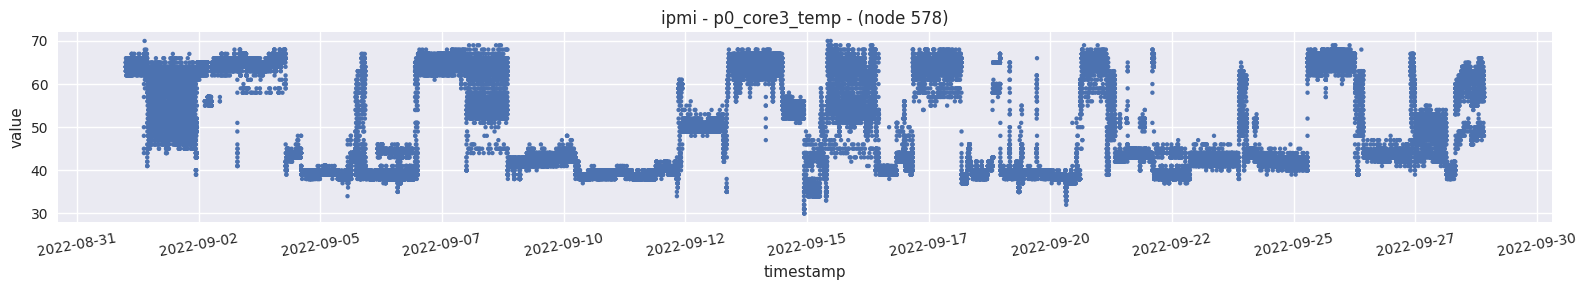

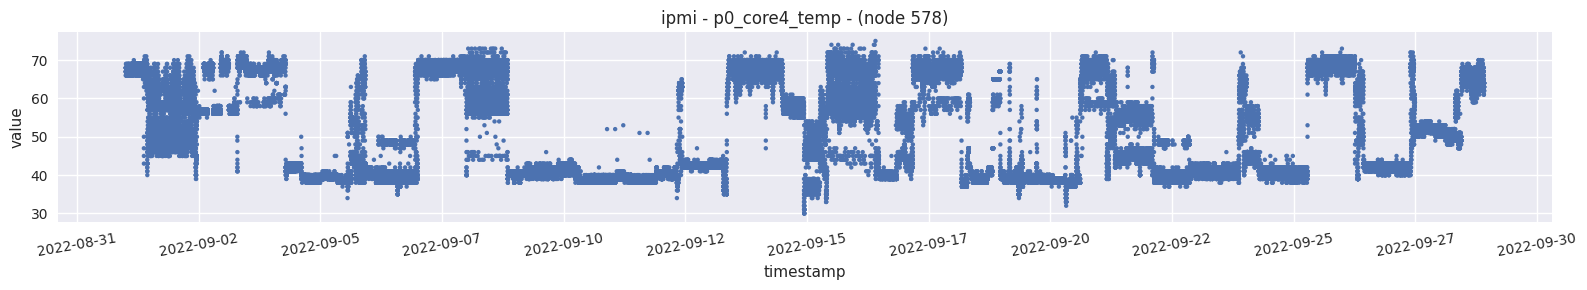

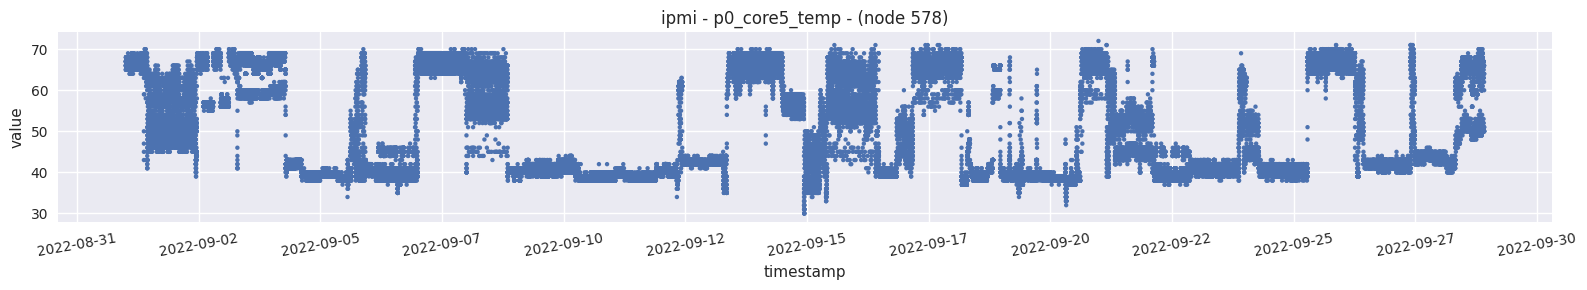

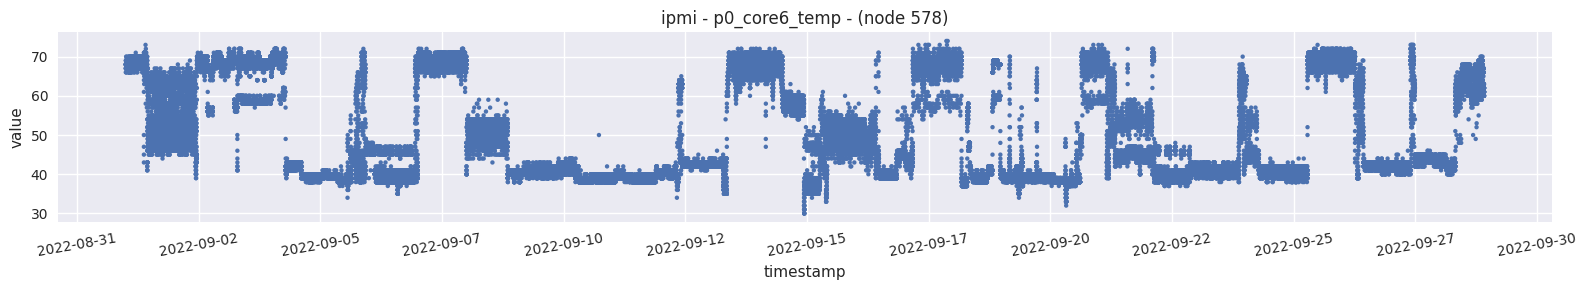

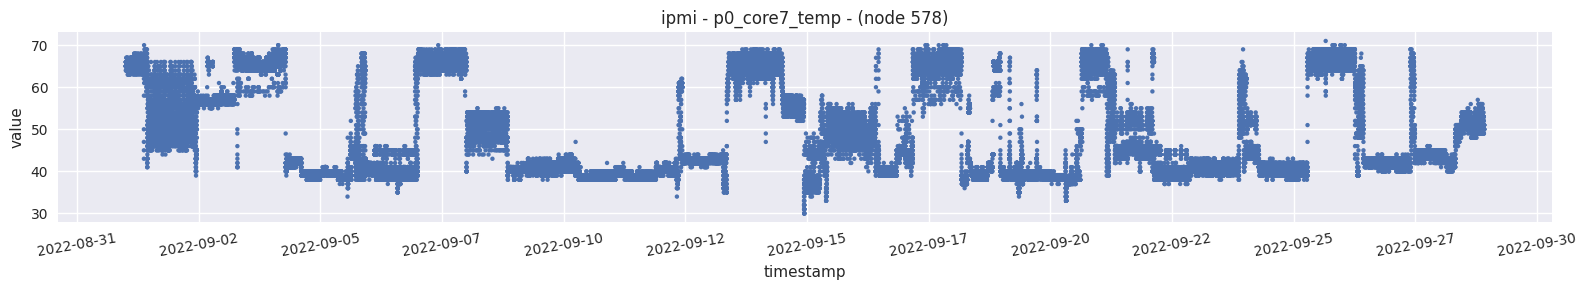

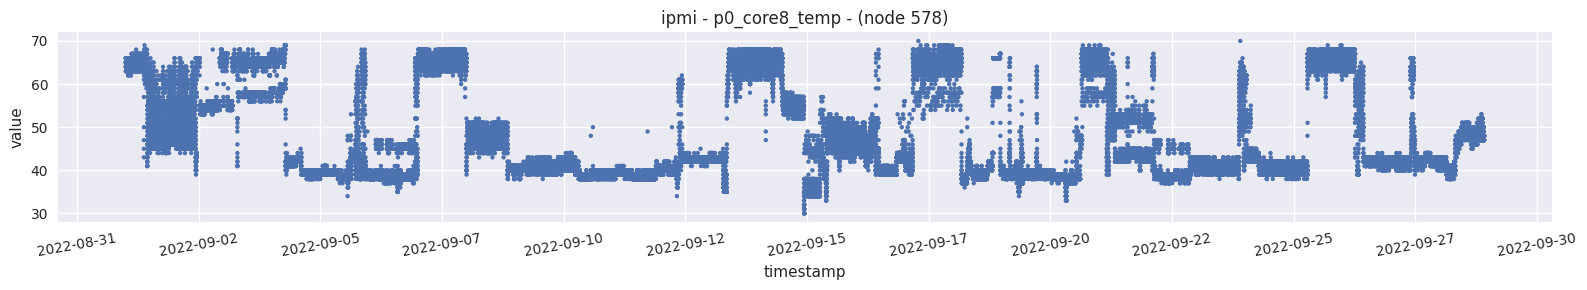

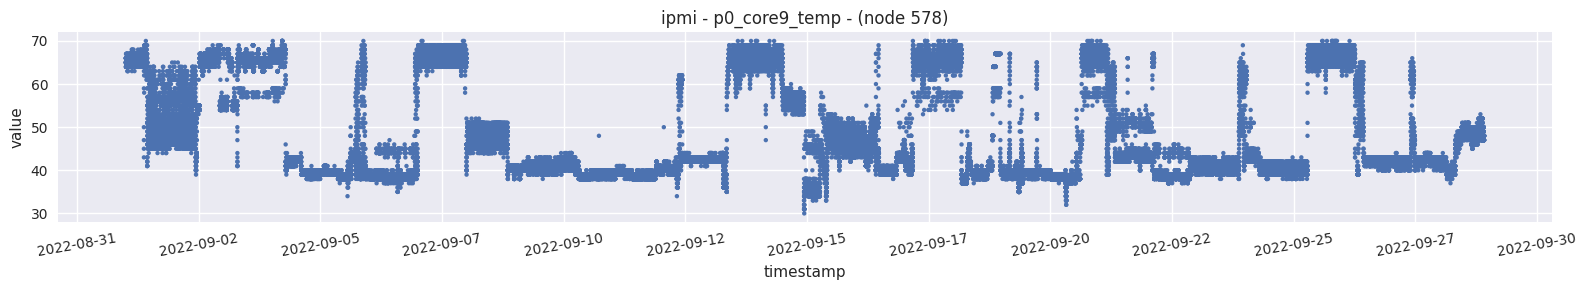

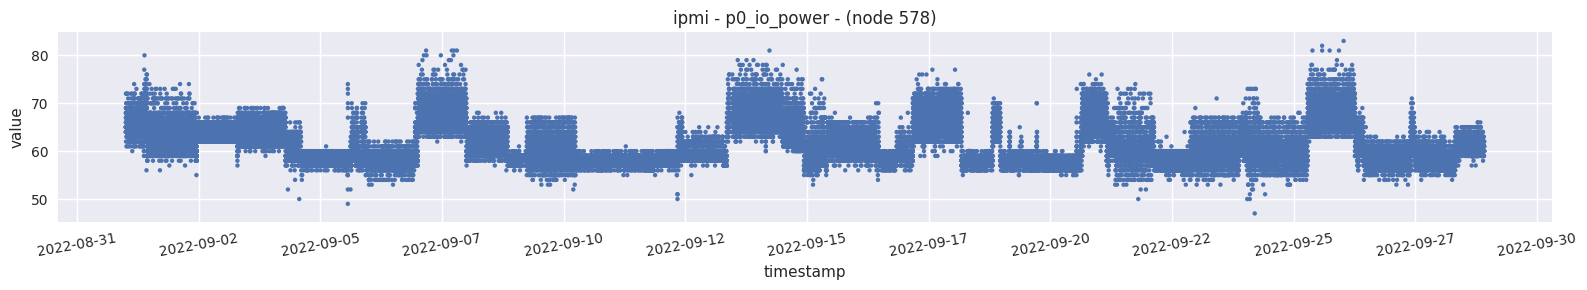

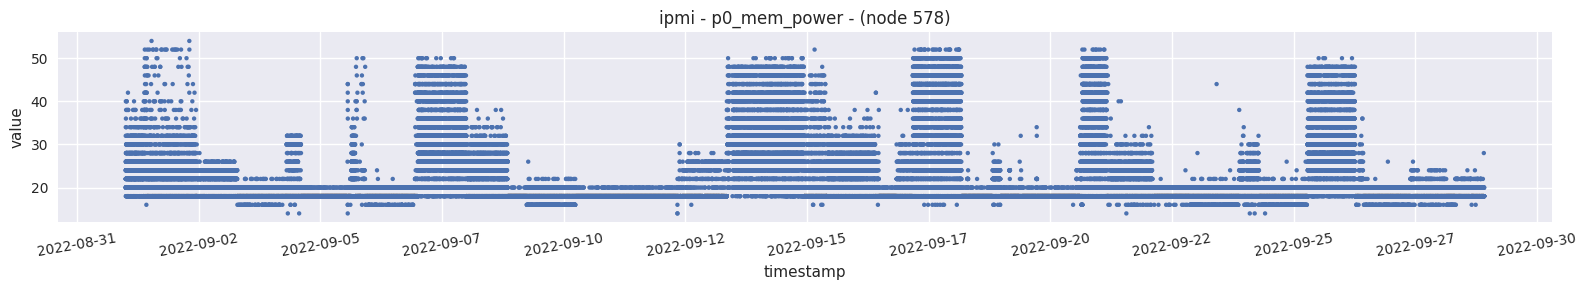

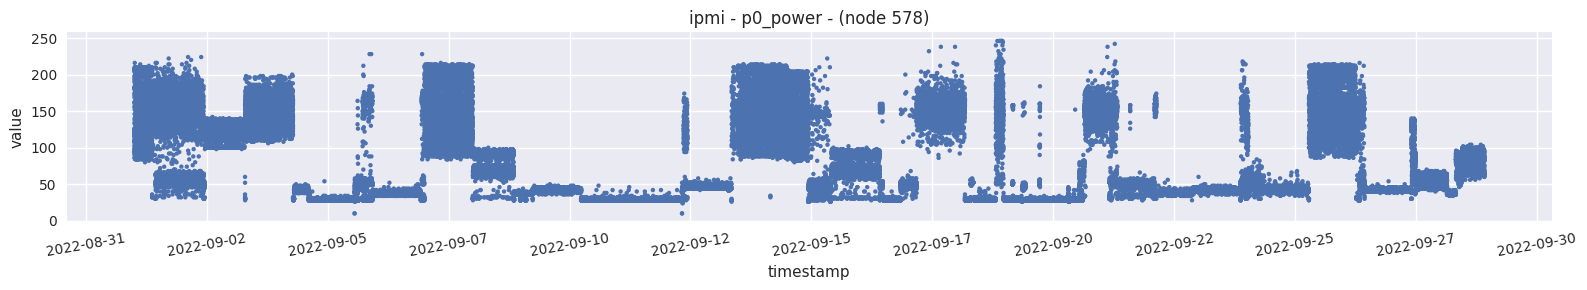

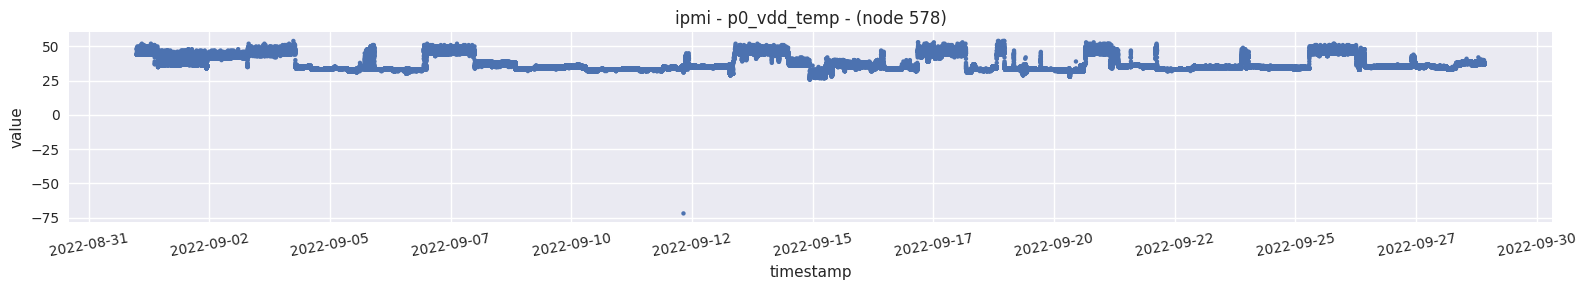

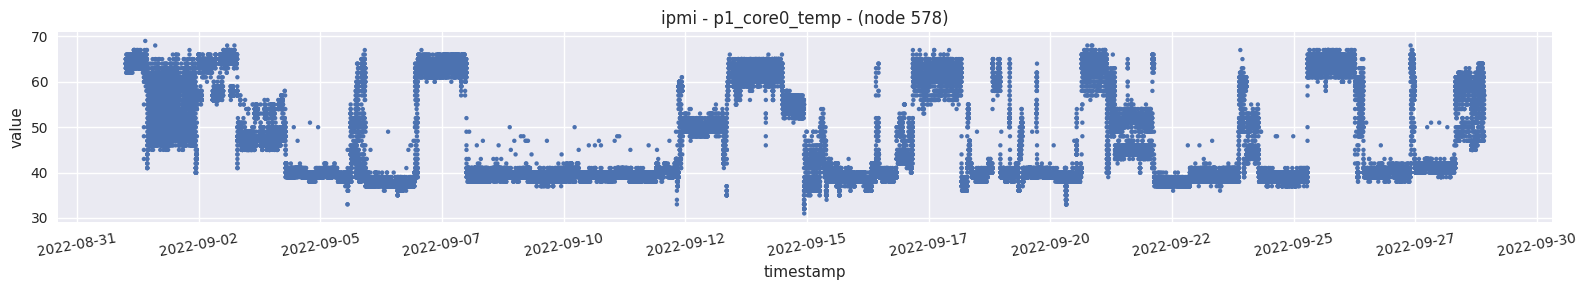

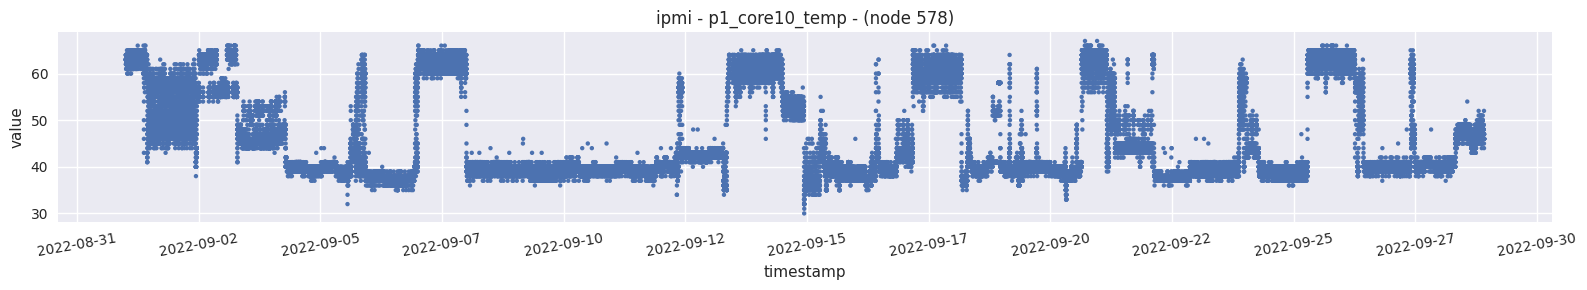

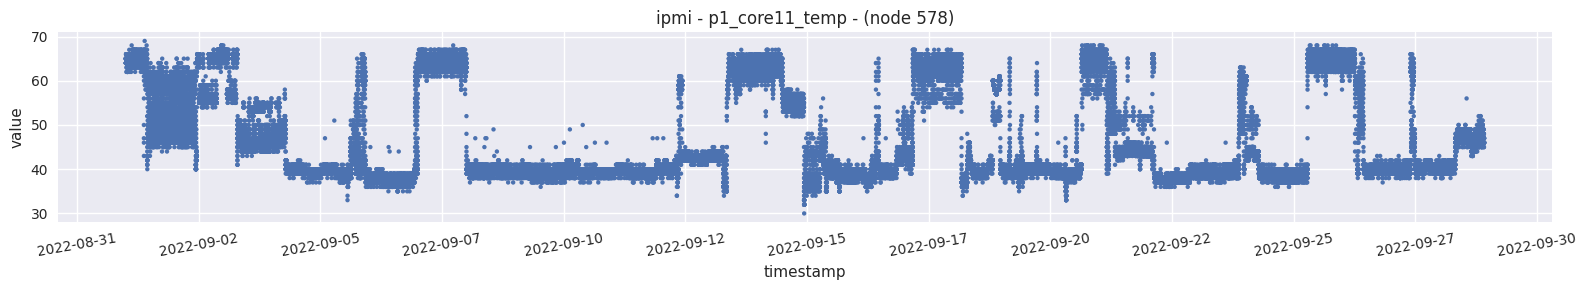

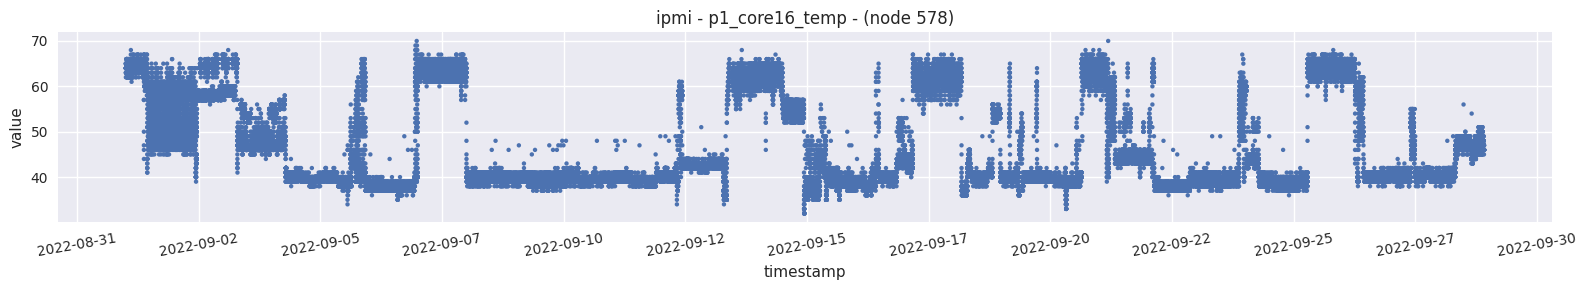

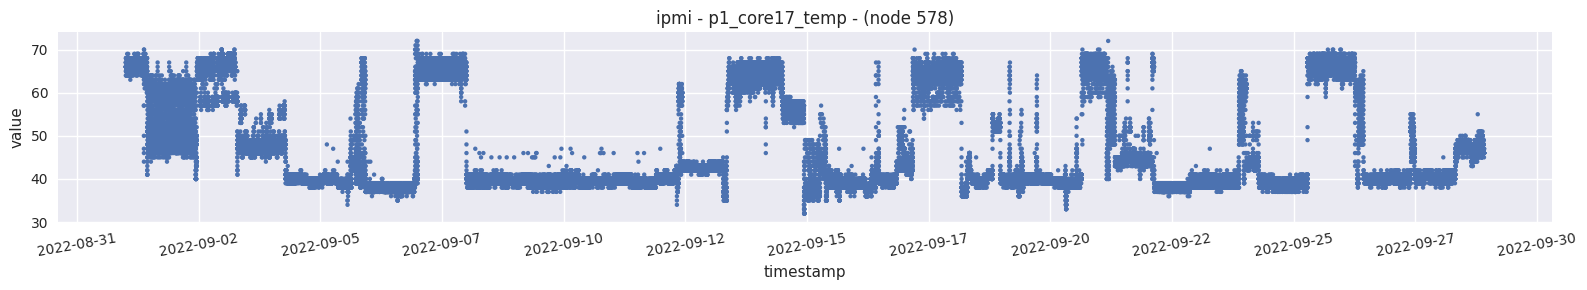

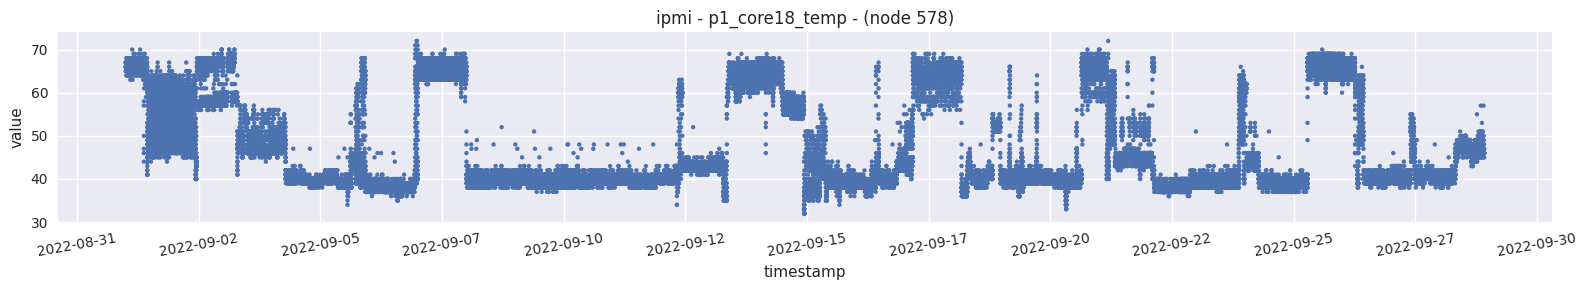

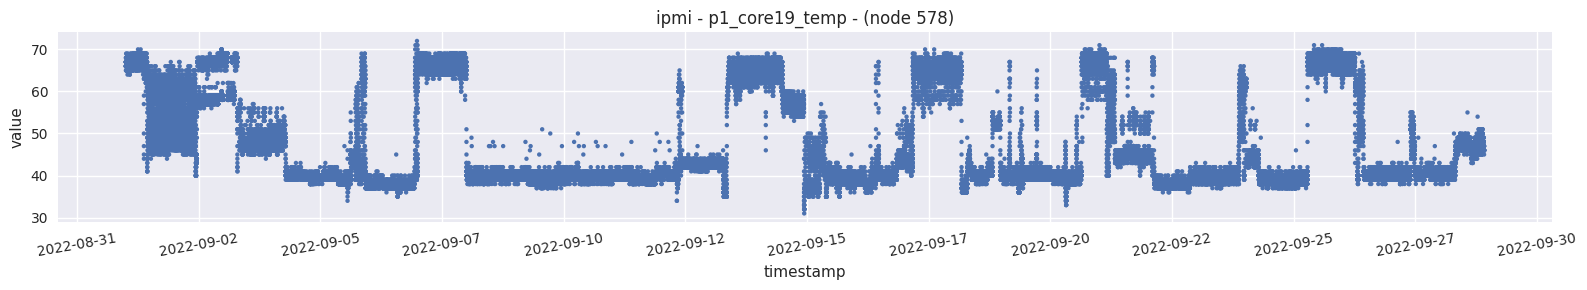

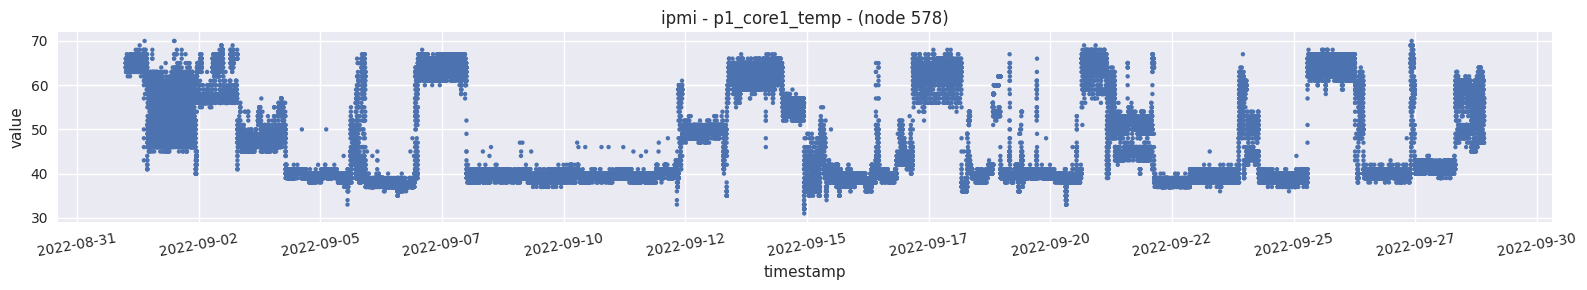

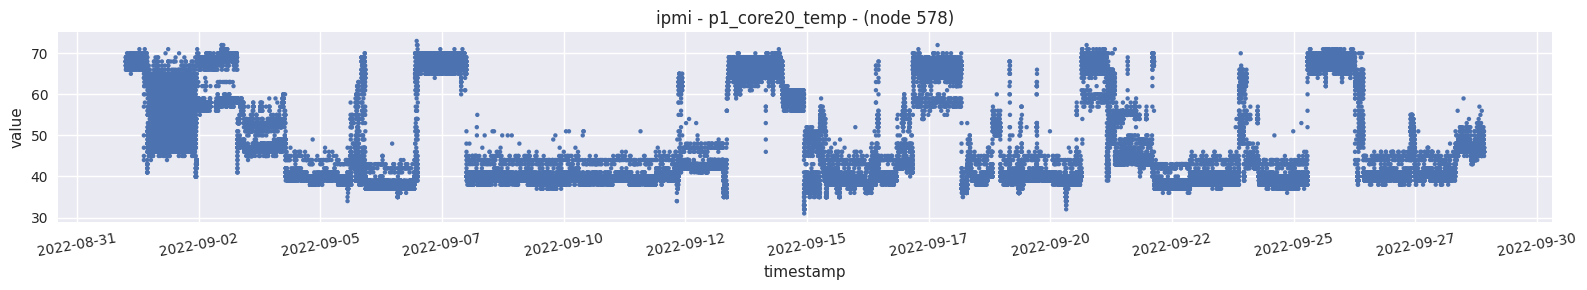

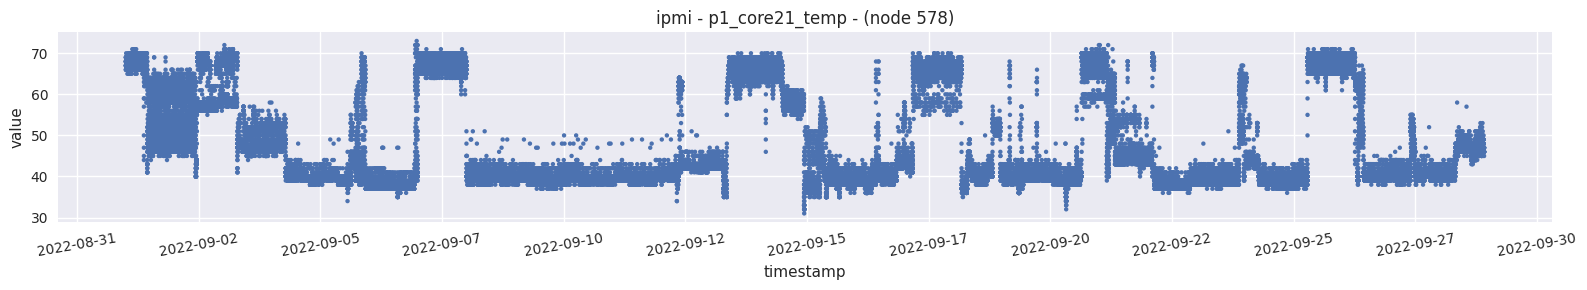

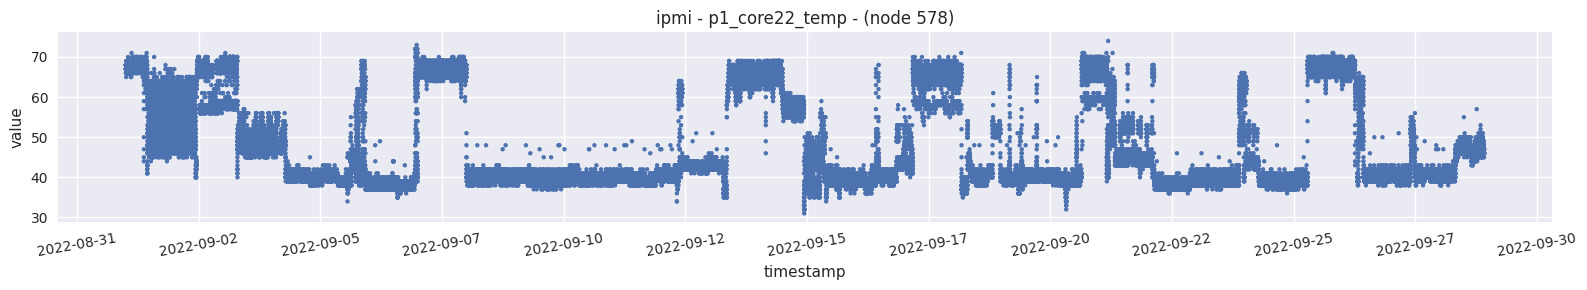

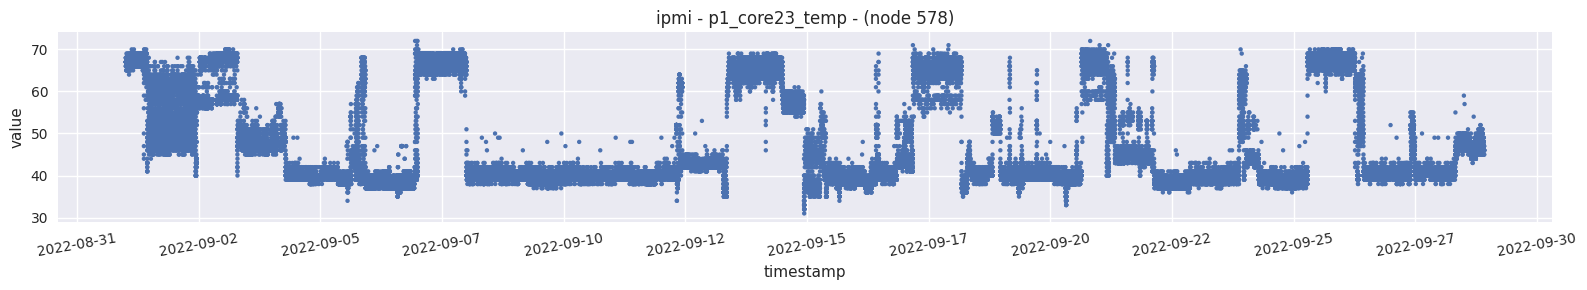

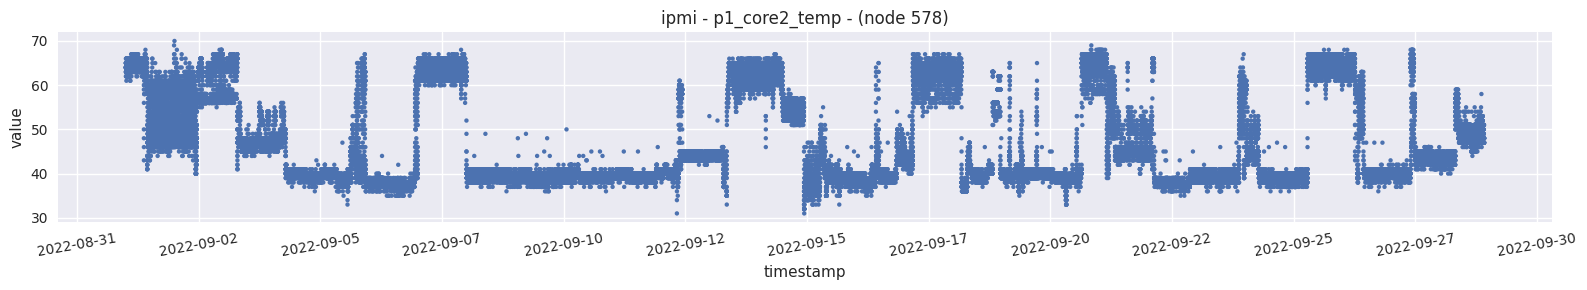

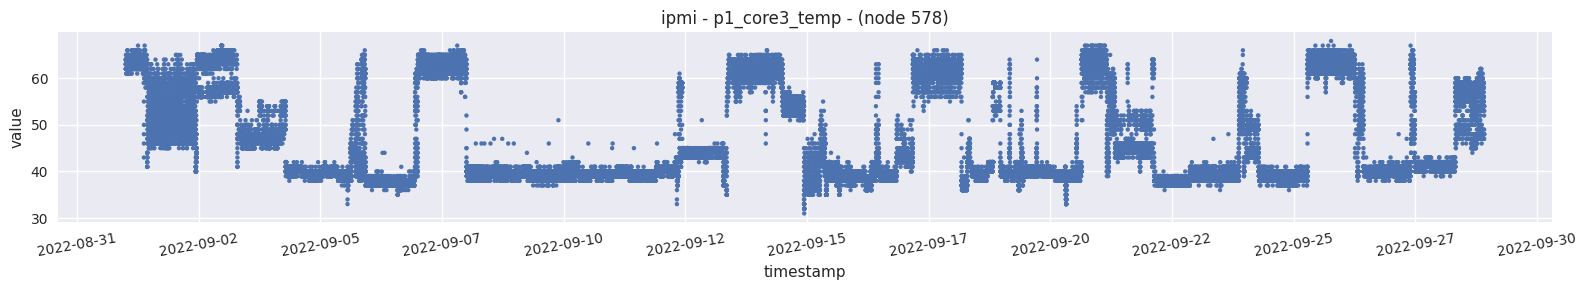

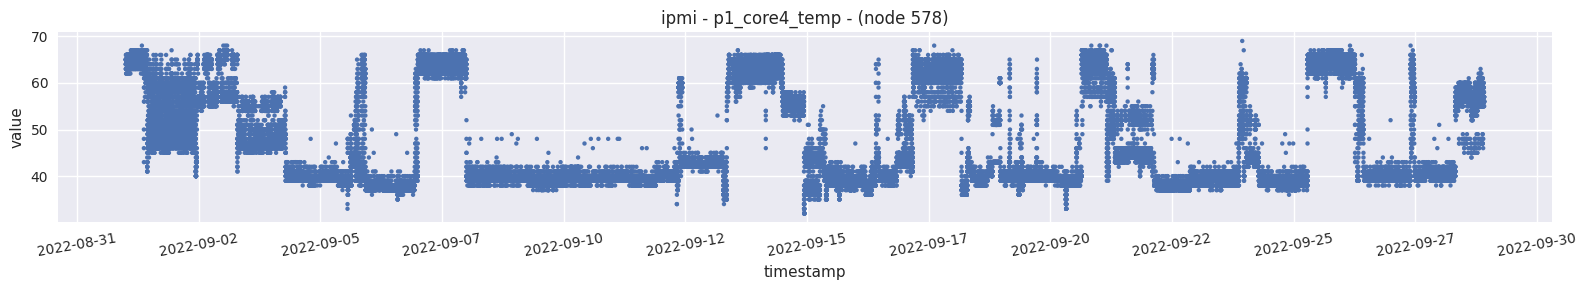

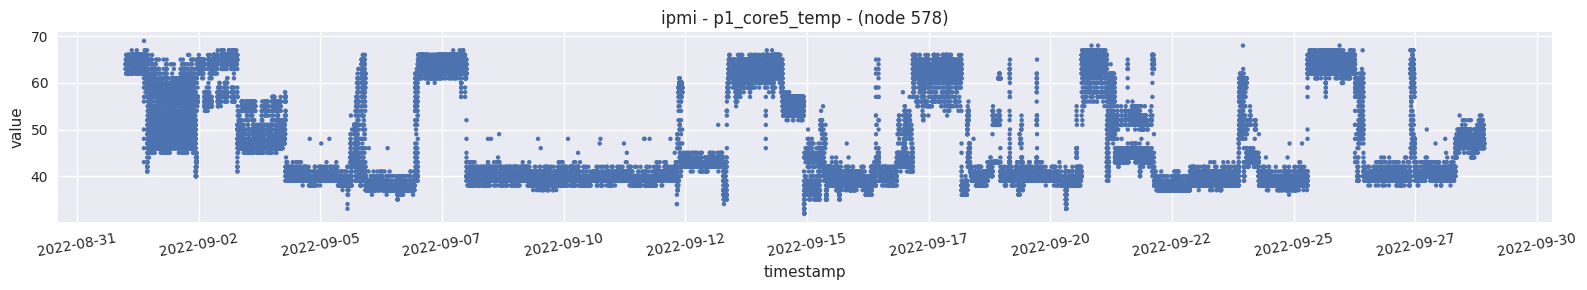

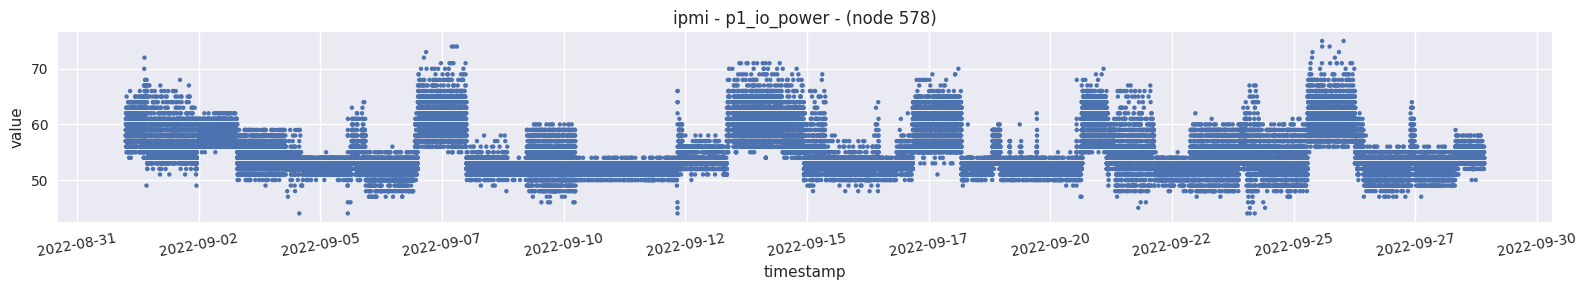

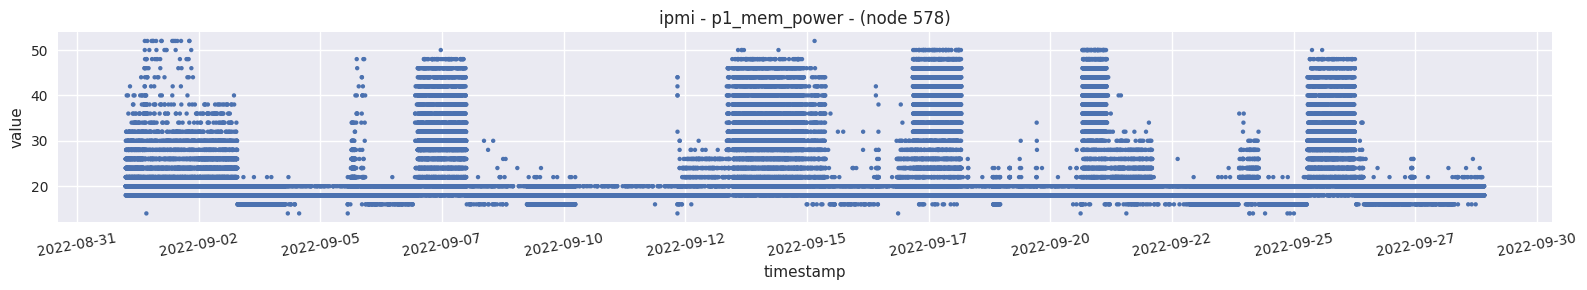

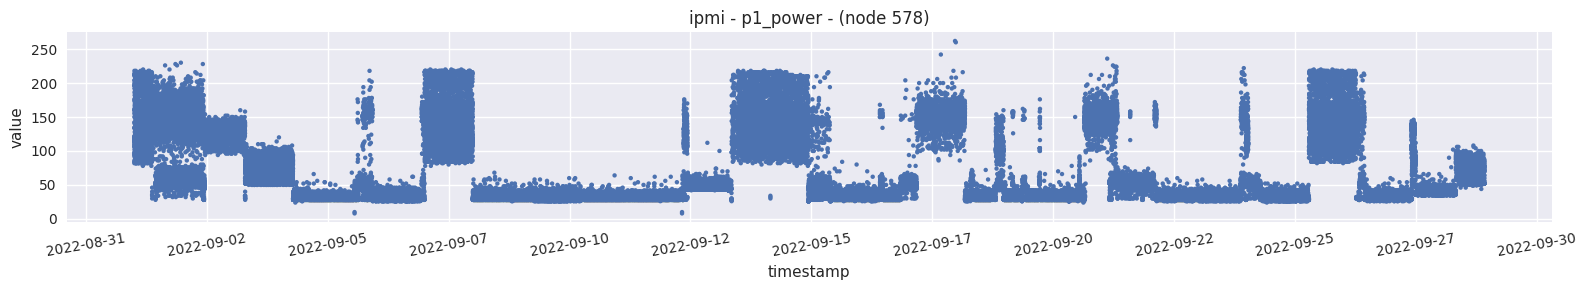

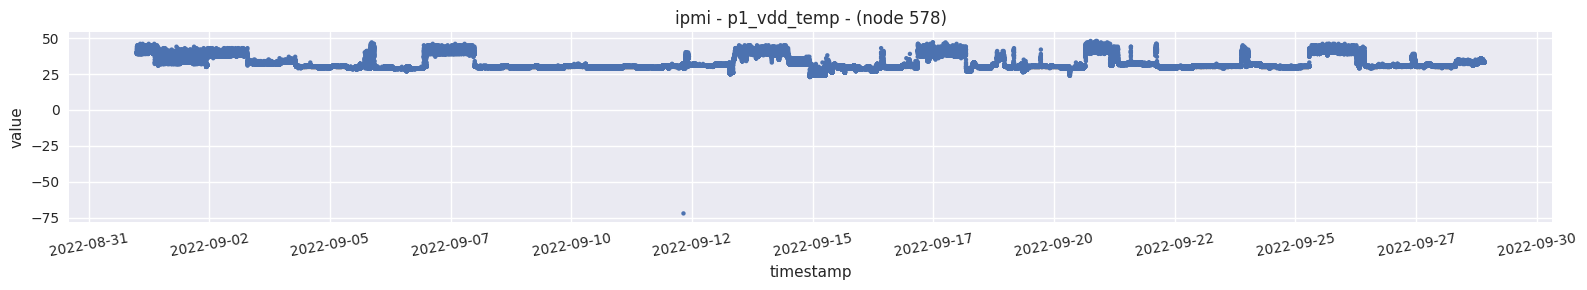

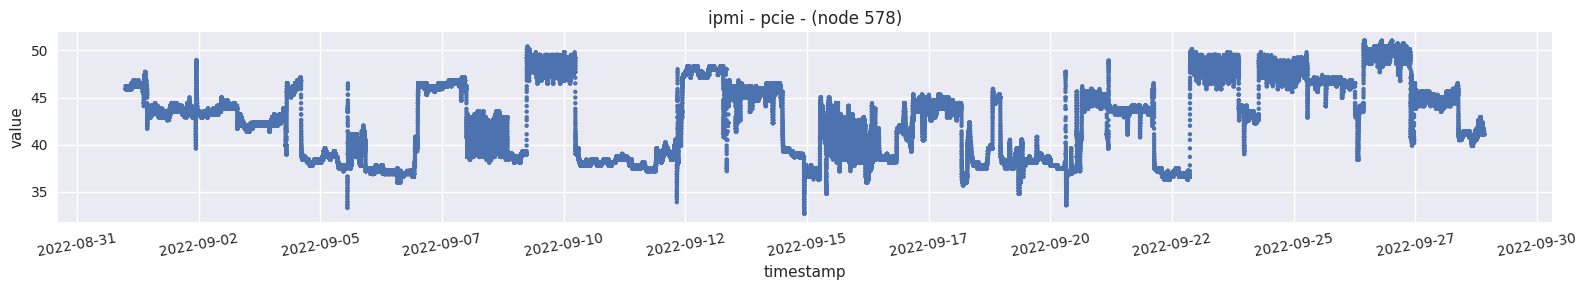

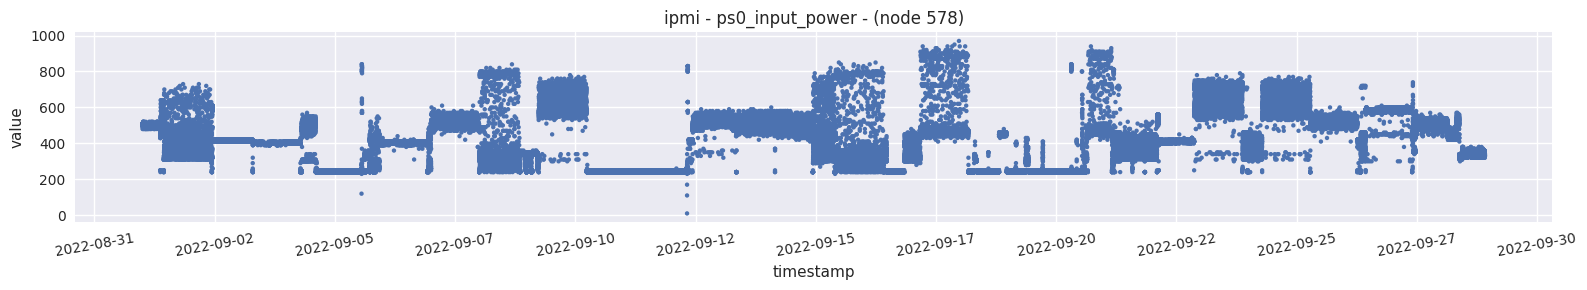

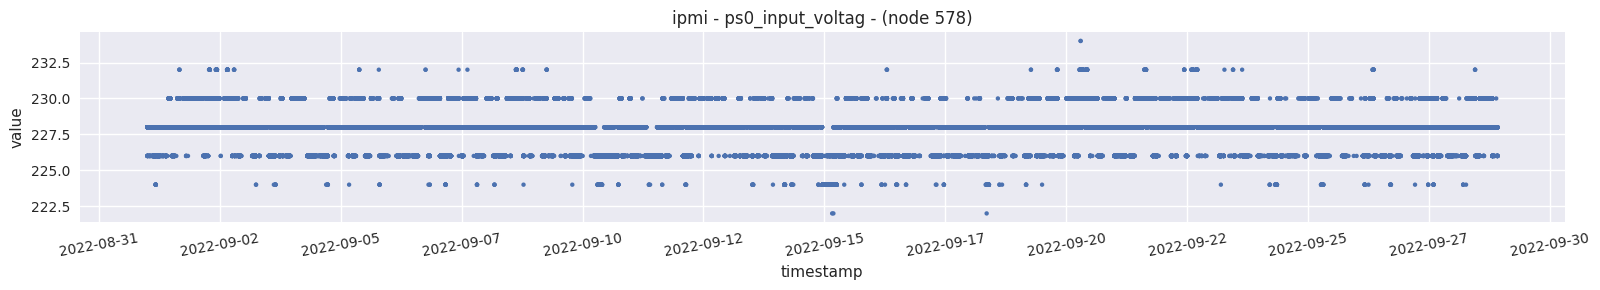

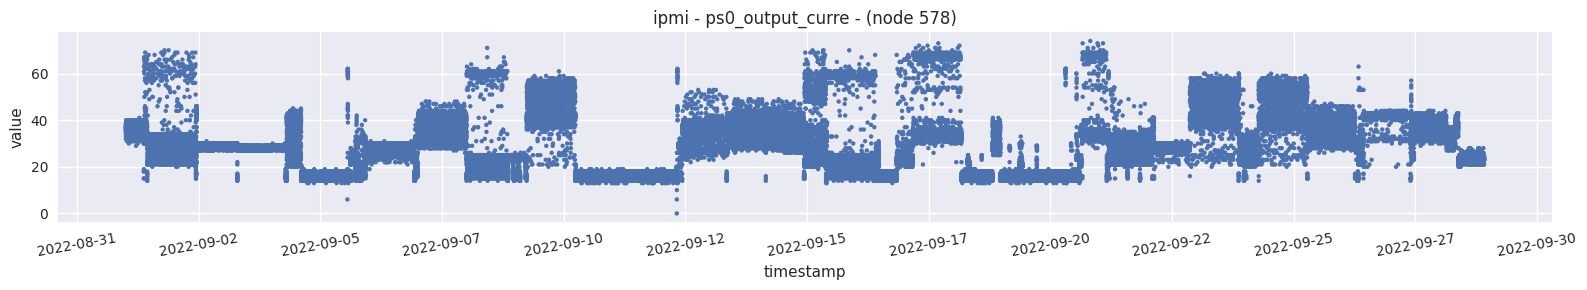

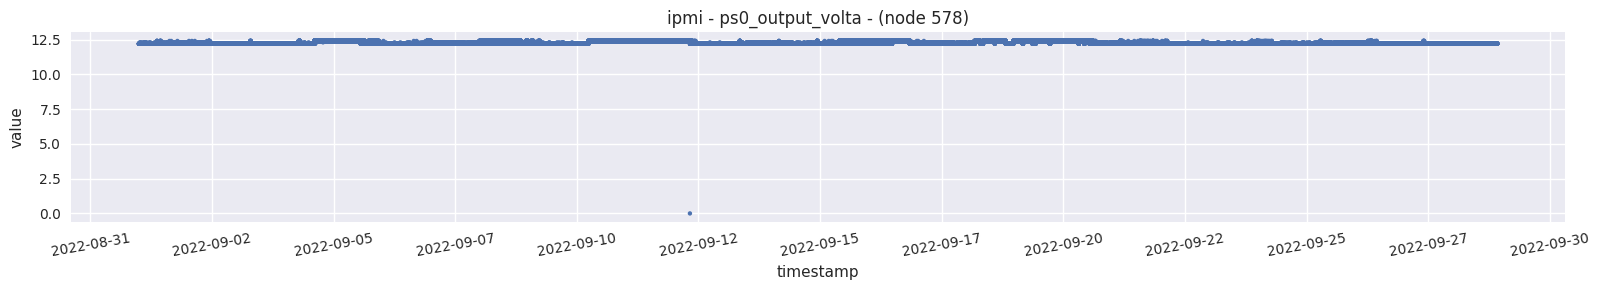

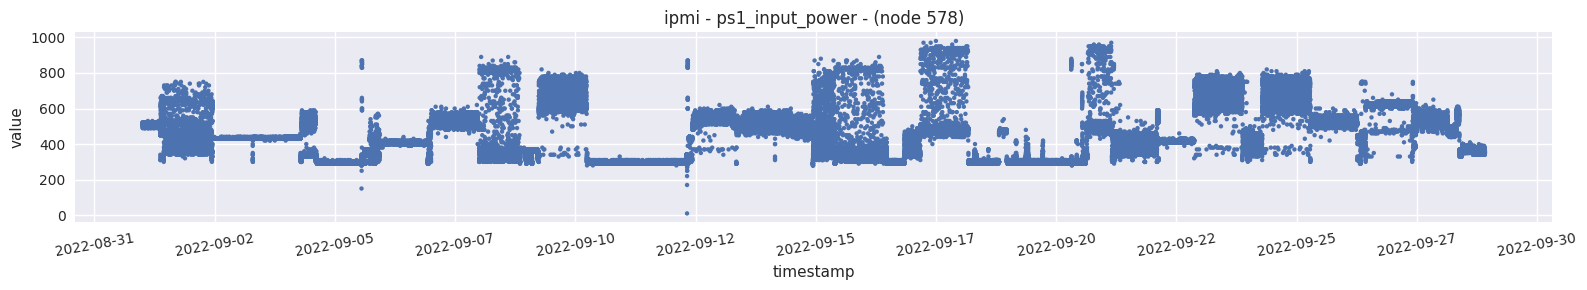

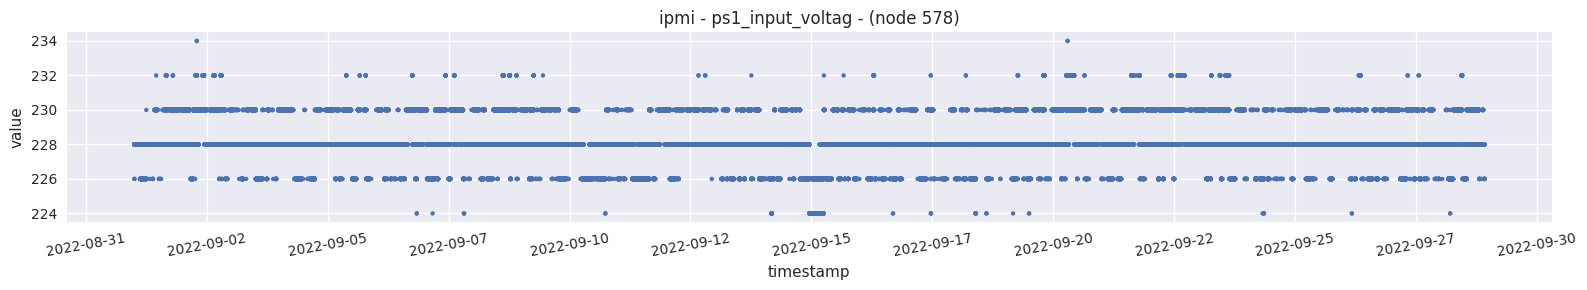

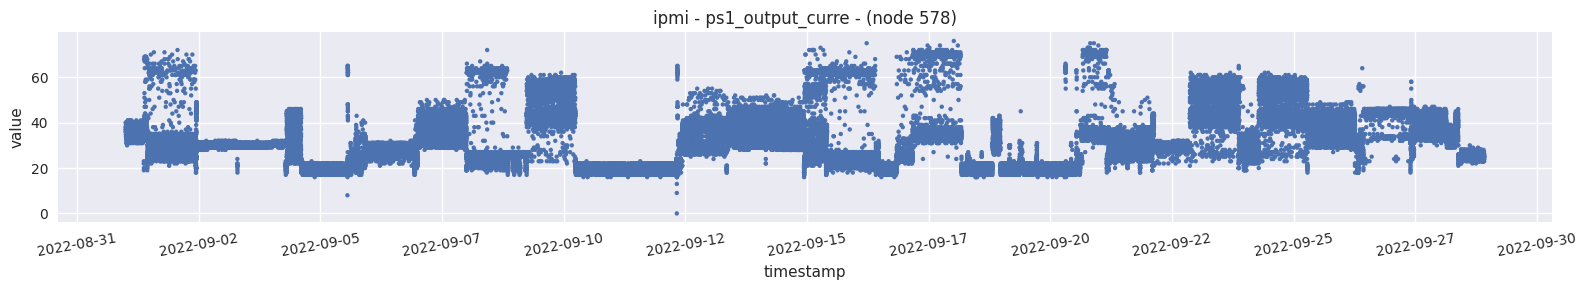

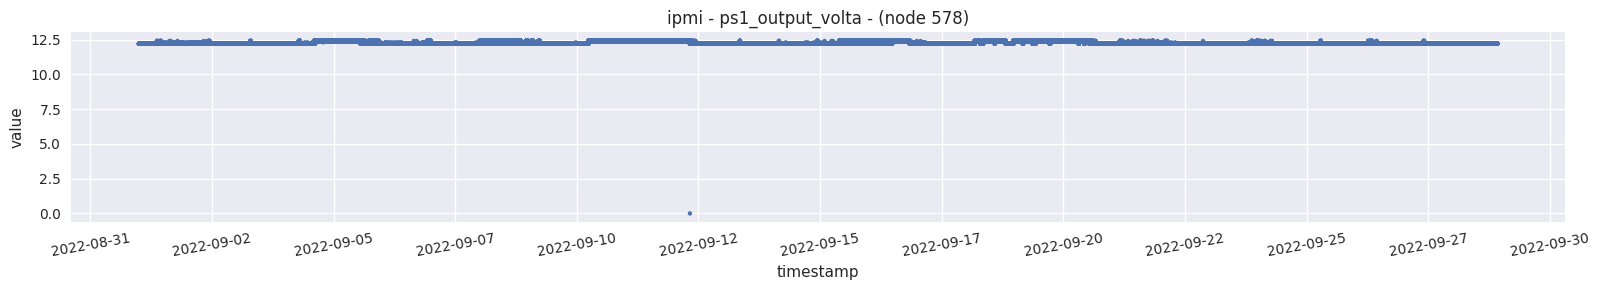

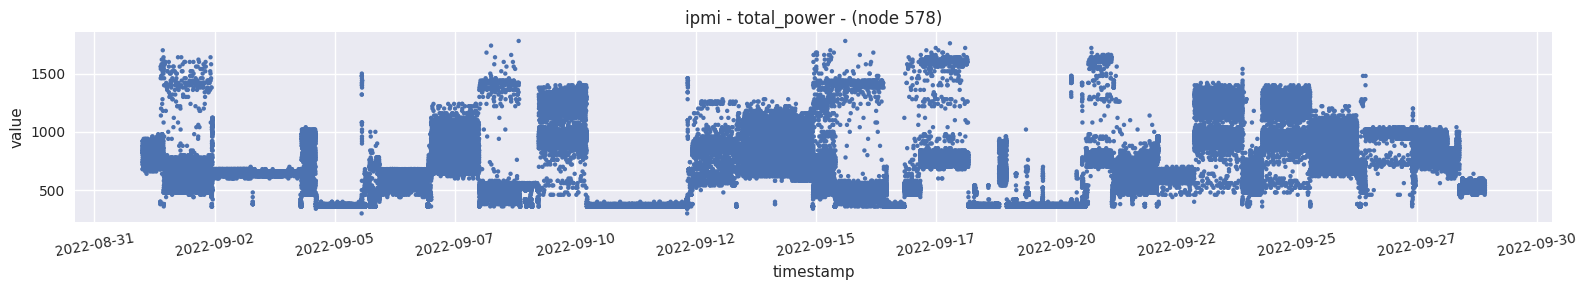

In [201]:
if DISPLAY_GRAPHS:
    for metric in metrics:
        _, axes = plt.subplots(figsize=(16, 3))
        df_ipmi_plot = df_ipmi.loc[df_ipmi["metric"] == metric][["timestamp", "value"]]
        sns.scatterplot(df_ipmi_plot, x="timestamp", y="value", edgecolor="none", s=10, ax=axes)
        axes.set_title("{} - {} - (node {})".format("ipmi", metric, NODE_SELECTED))
        axes.set_xticks(all_days)
        axes.tick_params(axis="x", labelrotation=10)
        axes.xaxis.set_major_locator(MaxNLocator(nbins=15))
        axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.tight_layout()
        plt.show()

## Verifications

In [202]:
# Null rows
if df_ipmi.shape[0] - df_ipmi.dropna().shape[0] != 0:
    raise Exception("There are null rows in the ipmi dataframe")

In [203]:
samples_per_metric(df_ipmi)

Total samples of nagios plugin: 2667 with timedelta of 0:15:00

Total samples per metric:
119860 	 of which unique 33	 for metric 'fan3_1'
		 with timedelta | MEAN: 0:00:20.123478 | MEDIAN: 0:00:20 | MAX: 0:54:00 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119849 	 of which unique 4	 for metric 'ps0_output_volta'
		 with timedelta | MEAN: 0:00:20.125325 | MEDIAN: 0:00:20 | MAX: 0:54:00 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119848 	 of which unique 77	 for metric 'ps1_input_power'
		 with timedelta | MEAN: 0:00:20.125493 | MEDIAN: 0:00:20 | MAX: 0:54:00 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119848 	 of which unique 14	 for metric 'dimm2_temp'
		 with timedelta | MEAN: 0:00:20.125493 | MEDIAN: 0:00:20 | MAX: 0:54:00 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119847 	 of which unique 78	 for metric 'ps0_input_power'
		 with timedelta | MEAN: 0:00:20.125661 | MEDIAN: 0:00:20 | MAX: 0:54:00 

## Build the new dataframe

In [204]:
df_ipmi_rebuild = rebuild_dataframe(df_ipmi)

In [205]:
# Aggregation timestamps according to nagios timedelta
df_ipmi_rebuild = aggregate_timestamps(df_ipmi_rebuild)

display(df_ipmi_rebuild.head(3))
df_ipmi_rebuild.info()

ambient  dimm0_temp  dimm10_temp  dimm11_temp  \
timestamp                                                                    
2022-09-01 00:00:00+00:00  23.537778        34.0    33.288889    32.644444   
2022-09-01 00:15:00+00:00  23.657778        34.0    33.733333         32.8   
2022-09-01 00:30:00+00:00  23.511111        34.0    33.466667    32.711111   

                           dimm12_temp  dimm13_temp  dimm14_temp  dimm15_temp  \
timestamp                                                                       
2022-09-01 00:00:00+00:00         34.0         34.0         33.0         35.0   
2022-09-01 00:15:00+00:00         34.0         34.0    33.288889         35.0   
2022-09-01 00:30:00+00:00         34.0         34.0    33.111111         35.0   

                           dimm1_temp  dimm2_temp  ...       pcie  \
timestamp                                          ...              
2022-09-01 00:00:00+00:00        34.0        34.0  ...  45.913335   
2022-09-01 00:15:00+00:00        34.0        34.0  ...  46.086668   
2022-09-01 00:30:00+00:00        34.0        34.0  ...  46.120001   

                           ps0_input_power  ps0_input_voltag  \
timestamp                                                      
2022-09-01 00:00:00+00:00       503.777778        227.644444   
2022-09-01 00:15:00+00:00       504.666667        227.822222   
2022-09-01 00:30:00+00:00       502.444444        227.955556   

                           ps0_output_curre  ps0_output_volta  \
timestamp                                                       
2022-09-01 00:00:00+00:00         35.844444              12.2   
2022-09-01 00:15:00+00:00         36.177778         12.202222   
2022-09-01 00:30:00+00:00         36.222222         12.202222   

                           ps1_input_power  ps1_input_voltag  \
timestamp                                                      
2022-09-01 00:00:00+00:00       511.111111        227.911111   
2022-09-01 00:15:00+00:00       511.555556             228.0   
2022-09-01 00:30:00+00:00       511.333333             228.0   

                           ps1_output_curre  ps1_output_volta  total_power  
timestamp                                                                   
2022-09-01 00:00:00+00:00         36.977778              12.2   820.444444  
2022-09-01 00:15:00+00:00         36.311111              12.2   809.777778  
2022-09-01 00:30:00+00:00         36.111111              12.2   810.222222  

[3 rows x 84 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2680 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Freq: 15T
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ambient           2676 non-null   Float64
 1   dimm0_temp        2676 non-null   Float64
 2   dimm10_temp       2676 non-null   Float64
 3   dimm11_temp       2676 non-null   Float64
 4   dimm12_temp       2676 non-null   Float64
 5   dimm13_temp       2676 non-null   Float64
 6   dimm14_temp       2676 non-null   Float64
 7   dimm15_temp       2676 non-null   Float64
 8   dimm1_temp        2676 non-null   Float64
 9   dimm2_temp        2676 non-null   Float64
 10  dimm3_temp        2676 non-null   Float64
 11  dimm4_temp        2676 non-null   Float64
 12  dimm5_temp        2676 non-null   Float64
 13  dimm6_temp        2676 non-null   Float64
 14  dimm7_temp        2676 non-null   Float64
 15  dimm8_temp        2676 non-null

In [206]:
# Save rebuilt dataframe
df_ipmi_rebuild.to_csv(dataset_path_rebuild + "/ipmi_rebuild_node:" + NODE_SELECTED + ".csv", index=True)

In [207]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^metrics$
%reset_selective -f ^metric$

# Job table

In [208]:
# This plugin has only one metric called 'job_info_marconi100' with different types of features

In [209]:
non_numerical_features = metrics_description(plugin="job_table")

Plugin: 'job_table'
metric: 'job_info_marconi100'
	dtype: None
	tags: ['plugin', 'metric', 'year_month', 'accrue_time', 'alloc_node', 'alloc_sid', 'array_job_id', 'array_max_tasks', 'array_task_id', 'array_task_str', 'array_task_throttle', 'assoc_id', 'batch_flag', 'batch_host', 'billable_tres', 'bitflags', 'boards_per_node', 'contiguous', 'cores_per_socket', 'cpus_alloc_layout', 'cpus_allocated', 'cpus_per_task', 'cpus_per_tres', 'dependency', 'derived_ec', 'eligible_time', 'end_time', 'exc_nodes', 'exit_code', 'features', 'group_id', 'job_id', 'job_state', 'last_sched_eval', 'max_cpus', 'max_nodes', 'mem_per_cpu', 'mem_per_node', 'min_memory_cpu', 'min_memory_node', 'nice', 'nodes', 'ntasks_per_board', 'ntasks_per_core', 'ntasks_per_core_str', 'ntasks_per_node', 'ntasks_per_socket', 'ntasks_per_socket_str', 'num_cpus', 'num_nodes', 'num_tasks', 'partition', 'pn_min_cpus', 'pn_min_memory', 'pn_min_tmp_disk', 'power_flags', 'priority', 'profile', 'qos', 'reboot', 'req_nodes', 'req_swit

In [210]:
df_jobtable: pd.DataFrame = client.query_plugins(plugins="job_table")

# Drop rows with NaN value in "nodes" feature
df_jobtable = df_jobtable.dropna(subset=["nodes"])

In [211]:
# Take only the rows of NODE_SELECTED
df_jobtable = df_jobtable.loc[
    list(
        map(
            lambda el: NODE_SELECTED in el,
            df_jobtable["nodes"]
            .str.replace("]", "")
            .str.replace("[", "")
            .str.replace(" ", "")
            .str.split(",")
            .to_list(),
        )
    )
]

In [212]:
# Sort
df_jobtable = df_jobtable.sort_values("submit_time").reset_index(drop=True)

# Drop empty features
df_jobtable = df_jobtable.dropna(axis=1)

df_jobtable.info()
display(df_jobtable.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   nodes              147 non-null    string             
 1   partition          147 non-null    category           
 2   contiguous         147 non-null    boolean            
 3   array_job_id       147 non-null    UInt32             
 4   job_id             147 non-null    UInt32             
 5   start_time         147 non-null    datetime64[ms, UTC]
 6   submit_time        147 non-null    datetime64[ms, UTC]
 7   job_state          147 non-null    category           
 8   nice               147 non-null    Int32              
 9   plugin             147 non-null    category           
 10  num_nodes          147 non-null    UInt16             
 11  qos                147 non-null    category           
 12  group_id           147 non-null    UInt32         

nodes partition  contiguous  array_job_id   job_id  \
0  [55, 432, 578, 831]         1       False       2137296  2137296   
1                [578]         1       False       4925546  4925546   
2                [578]         1       False       2840337  2840337   

                 start_time               submit_time  job_state  nice  \
0 2022-09-01 10:35:57+00:00 2022-07-20 15:15:04+00:00     FAILED     0   
1 2022-09-13 08:26:31+00:00 2022-08-23 19:53:41+00:00  COMPLETED     0   
2 2022-09-14 03:40:52+00:00 2022-08-23 19:54:46+00:00  COMPLETED     0   

      plugin  num_nodes qos  group_id                    cpus_alloc_layout  \
0  job_table          4   1     25200  {831: [], 432: [], 578: [], 55: []}   
1  job_table          1   1     25200                            {578: []}   
2  job_table          1   1     25200                            {578: []}   

   priority               metric  num_cpus  user_id time_limit_str  \
0    146942  job_info_marconi100       512     1681     1-00:00:00   
1    137665  job_info_marconi100       128     1529     1-00:00:00   
2    137848  job_info_marconi100       128     1529     1-00:00:00   

                   end_time  
0 2022-09-02 10:29:33+00:00  
1 2022-09-14 03:39:58+00:00  
2 2022-09-14 22:30:17+00:00

In [213]:
job_states = df_jobtable["job_state"].unique()

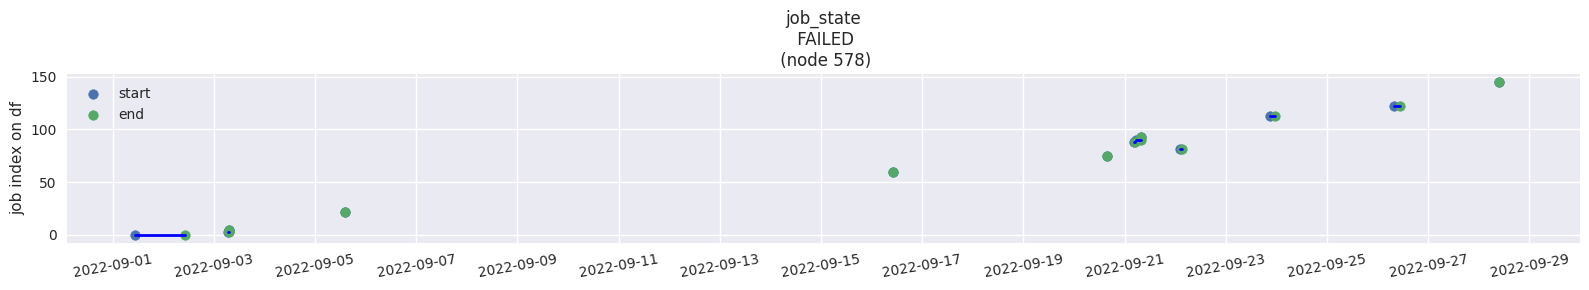

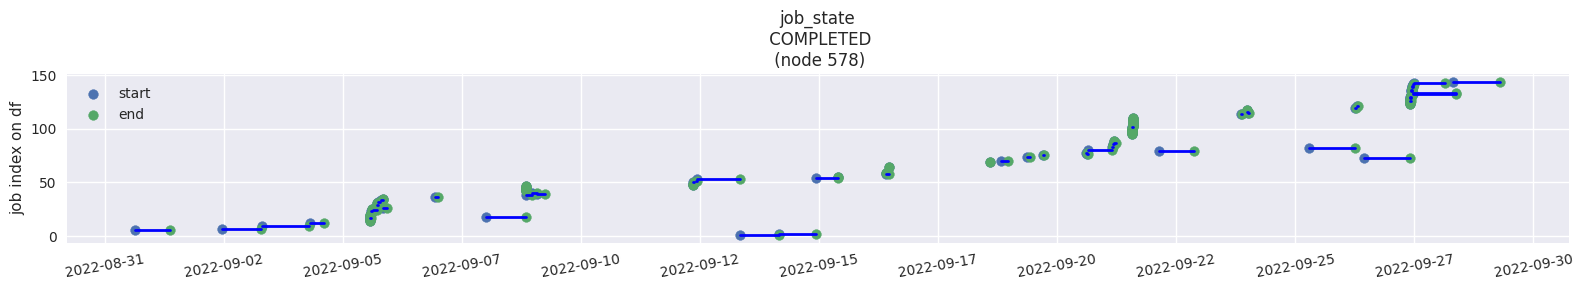

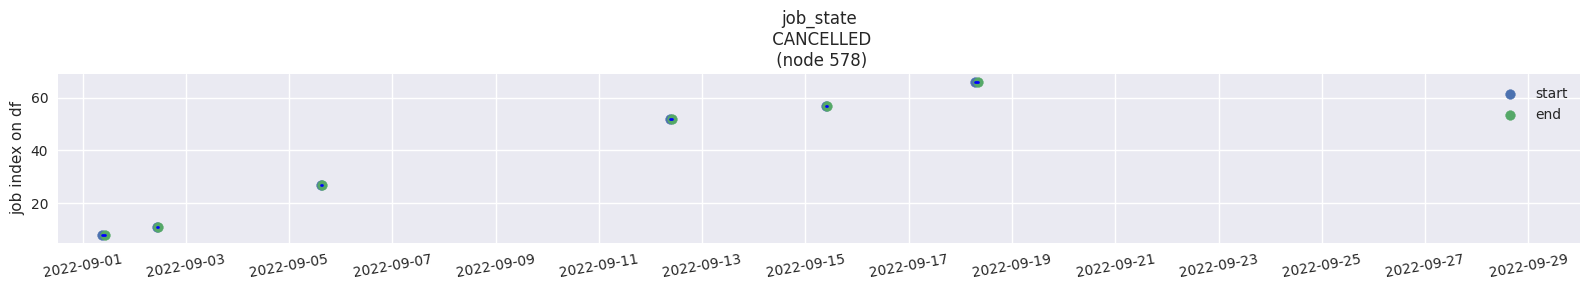

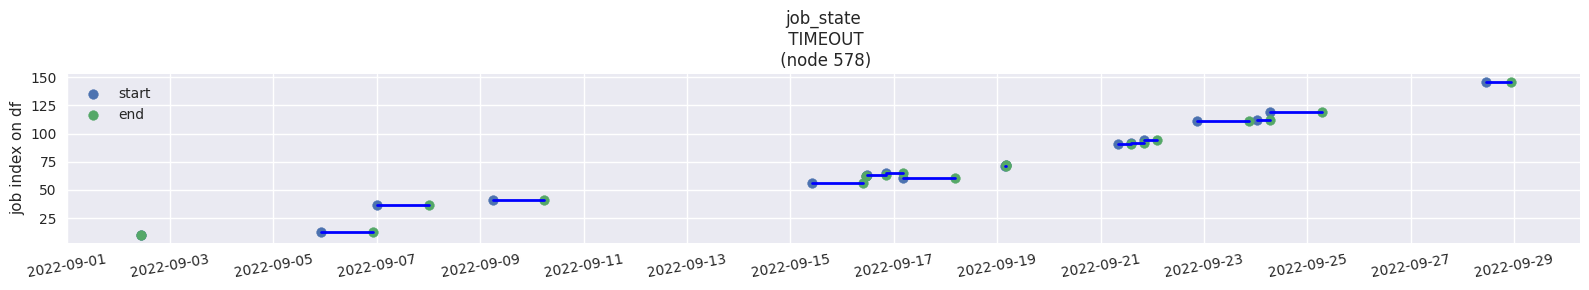

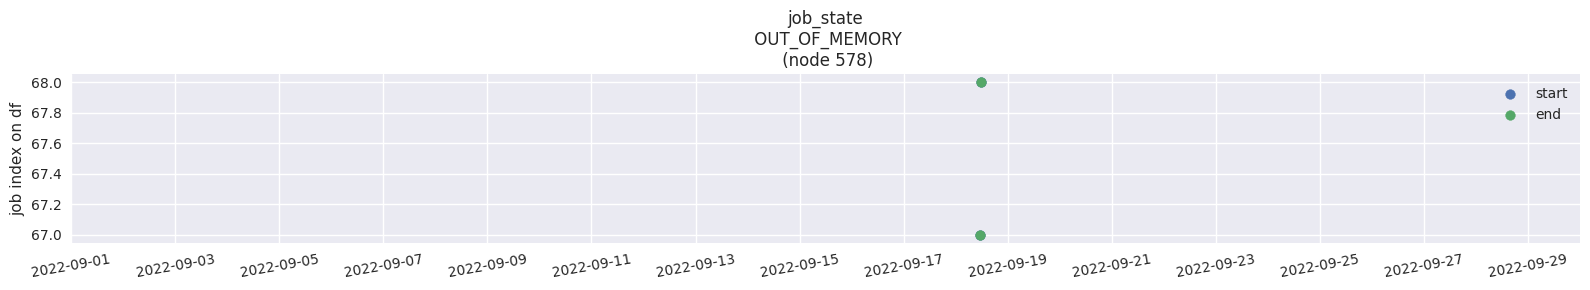

In [214]:
# Display, for each job, execution start and end time points, connected with a line

if DISPLAY_GRAPHS:
    for descr in job_states:
        _, axes = plt.subplots(figsize=(16, 3))
        df_jobtable_plot = df_jobtable.loc[df_jobtable["job_state"] == descr]

        axes.scatter(df_jobtable_plot["start_time"], df_jobtable_plot.index, label="start")
        axes.scatter(df_jobtable_plot["end_time"], df_jobtable_plot.index, label="end")

        for index, row in df_jobtable_plot.iterrows():
            axes.plot([row["start_time"], row["end_time"]], [index, index], color="b", linewidth=2)

        axes.legend()
        axes.set_title("{}\n {}\n (node {})".format("job_state", descr, NODE_SELECTED))
        axes.set_xticks(all_days)
        axes.tick_params(axis="x", labelrotation=10)
        axes.xaxis.set_major_locator(MaxNLocator(nbins=15))
        axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        axes.set_ylabel("job index on df")
        plt.tight_layout()
        plt.show()

### Problem:
what can be the purpouse of this data?
maybe setting the a new "idle" state to the moments when the node is not executing jobs, adding "empty" rows according to the nagios timestamp

In [215]:
%reset_selective -f ^df_jobtable
%reset_selective -f ^job_states$
%reset_selective -f ^descr$
%reset_selective -f ^ax
%reset_selective -f ^index$
%reset_selective -f ^row$

---
# Logics

In [216]:
non_numerical_features = metrics_description(plugin="logics")

Plugin: 'logics'
metric: 'deviceid'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Tot'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Volt2'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Potenza_attiva'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'pit'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Corrente_L3'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Volt3'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Pue'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'ID_Modbus'
	dtype: int32
	tags: ['plugin', 'metric', 'year

In [217]:
df_logics = client.query_plugins(plugins="logics")

df_logics.info()
display(df_logics.head(3))

/home/riccardo/Anomaly-Detection/query_tool/query_tool.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, table.to_pandas(**to_pandas_kwargs)], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38835580 entries, 0 to 38835579
Data columns (total 7 columns):
 #   Column      Dtype              
---  ------      -----              
 0   device      object             
 1   value       Float64            
 2   plugin      category           
 3   panel       object             
 4   year_month  category           
 5   metric      category           
 6   timestamp   datetime64[ms, UTC]
dtypes: Float64(1), category(3), datetime64[ms, UTC](1), object(2)
memory usage: 1.3+ GB


device  value      plugin       panel year_month      metric  \
0  qe-20a-n    1.0  logics_pub  marconi-a3        NaN  Bad_values   
1  qe-20a-n    0.0  logics_pub  marconi-a3        NaN  Bad_values   
2  qe-20a-n    1.0  logics_pub  marconi-a3        NaN  Bad_values   

                  timestamp  
0 2022-09-04 12:25:50+00:00  
1 2022-09-04 12:26:50+00:00  
2 2022-09-04 12:33:53+00:00

### Problem
the position of the node w.r.t. the panel code is not available

In [218]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features$

---
# Schneider

In [219]:
metrics_description(plugin="schneider")

Plugin: 'schneider'
metric: 'PLC_PLC_Q101.Min_vel_pompe'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Rif_auto_p101'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Alm_nostart_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Temp_ritorno'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.V_ore_tot_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Alm_inverter_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.T_scambio_quadri'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Manuale_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp

[]

In [220]:
df_schneider = client.query_plugins(plugins="schneider")

df_schneider.info()
display(df_schneider.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33554432 entries, 0 to 33554431
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   value       Int32              
 1   plugin      category           
 2   panel       category           
 3   year_month  category           
 4   metric      category           
 5   timestamp   datetime64[ms, UTC]
dtypes: Int32(1), category(4), datetime64[ms, UTC](1)
memory usage: 576.0 MB


value         plugin panel year_month     metric                 timestamp
0      0  schneider_pub  Q101        NaN  Alm_TY141 2022-09-23 22:00:00+00:00
1      0  schneider_pub  Q101        NaN  Alm_TY141 2022-09-23 23:00:00+00:00
2      0  schneider_pub  Q101        NaN  Alm_TY141 2022-09-02 22:00:00+00:00

### Problem
the position of the node w.r.t. the panel code is not available

In [221]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features$

---
# Slurm 

In [222]:
metrics_description(plugin="slurm")

Plugin: 'slurm'
metric: 'total_memory_eligible'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.jobs.tot_gpus'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'qos', 'partition', 'job_state']
metric: 'cluster_cpu_util'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 'total_memory_down'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 'total_memory_config'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.jobs.nodes_eligible'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'qos', 'partition', 'job_state']
metric: 'cluster_memory_util'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.totals.total_nodes_down'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'partition']
metric: 's21.jobs.eligible_v2'
	dt

[]

In [223]:
df_slurm = client.query_plugins(plugins="slurm")

df_slurm.info()
display(df_slurm.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59574539 entries, 0 to 59574538
Data columns (total 9 columns):
 #   Column      Dtype              
---  ------      -----              
 0   user_id     UInt32             
 1   qos         category           
 2   partition   category           
 3   job_state   category           
 4   value       Float64            
 5   timestamp   datetime64[ms, UTC]
 6   year_month  category           
 7   metric      category           
 8   plugin      category           
dtypes: Float64(1), UInt32(1), category(6), datetime64[ms, UTC](1)
memory usage: 1.6 GB


user_id  qos partition  job_state      value                 timestamp  \
0      393  NaN         1     FAILED  1348166.0 2022-09-14 22:00:00+00:00   
1      366  NaN         1  COMPLETED  1653075.0 2022-09-07 22:00:00+00:00   
2      478  NaN         1  COMPLETED  1147583.0 2022-09-13 23:00:00+00:00   

  year_month  metric     plugin  
0        NaN  job_id  slurm_pub  
1        NaN  job_id  slurm_pub  
2        NaN  job_id  slurm_pub

### Problem
the position of the node w.r.t. the partition code is not available

In [224]:
%reset_selective -f ^df_
%reset_selective -f ^ax